# Initial

## Importing and Reading

In [1]:
#General Imports.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2

In [2]:
#Reading CSV files.
df_protein_median = pd.read_csv('Data\data files\iNPH_data_protein_median.csv', index_col=0)
df_protein_no_n = pd.read_csv('Data\data files\iNPH_data_protein_nonormalization.csv', index_col=0)
df_peptide_median = pd.read_csv('Data\data files\iNPH_data_peptide_median.csv', index_col=0)
df_peptide_no_n = pd.read_csv('Data\data files\iNPH_data_peptide_nonormalization.csv', index_col=0)

## Data knowledge

In [3]:
#channel.names                     = Combination of TMT Set and Pos.
#Sample_Run_ID                     = Arbitrary ID (remapped to 1-106).
#TMT Set                           = The set of up to 18 samples that was tested simultaneously.
#TMT Pos                           = The position in the set a sample had.
#CSF_type                          = L (lumbar) or V (ventricular) CSF sample.
#Diagnostic_classification_string3 = iNPH + comorbid condition (AD or VCI(Vascular Cognitive Impairment)).
#Cortical_biopsy_grouping          = 0 (no AD), 1 (early stage), 2 (later stage).
#Abeta_score                       = 0-3 scale of amount of pathological lesions (Abeta plaques) in brain sample.
#Tau_score                         = 0-3 scale of amount of pathological lesions (tau tangles) in brain sample.
#Gender                            = Gender of sampled individual
#Age_at_biopsy                     = Age of sampled individual
#Proteins                          = Comes in the form Q14515 (Accession number).
#Peptides                          = Accession number followed by position of peptide in protein (Q14515..533.552).

## Cleaning functions

In [4]:
def replace_inf_with_nan(df):
    """
    Replace inf and -inf with nan.

    :param df: Dataframe to clean inf and -inf from.
    :return: df without inf and -inf.
    """ 
    return df.replace([np.inf, -np.inf], np.nan)

In [5]:
def remapp_id(df):
    """
    Remaps the arbitrary Sample_Run_ID with ID.

    :param df: Dataframe to remap Sample_Run_ID
    :return: df with ID.
    """ 
    value_mapping = {value: i + 1 for i, value in enumerate(df['Sample_Run_ID'].unique())}
    df['Sample_Run_ID'] = df['Sample_Run_ID'].map(value_mapping)
    return df

In [6]:
def replace_nan_with_zero(df):
    """
    Replace nan with zero.

    :param df: Dataframe to clean nan from.
    :return: df without nan.
    """ 
    return df.replace([np.nan, np.NaN], 0)

## Cleaning

In [7]:
#Remove inf and remapp id.
df_protein_median = remapp_id(replace_inf_with_nan(df_protein_median))
df_protein_no_n = remapp_id(replace_inf_with_nan(df_protein_no_n))
df_peptide_median = remapp_id(replace_inf_with_nan(df_peptide_median))
df_peptide_no_n = remapp_id(replace_inf_with_nan(df_peptide_no_n))

In [8]:
#Extracting only protein data.
protein_median = df_protein_median.iloc[:,11:]
protein_no_n = df_protein_no_n.iloc[:,11:]
peptide_median = df_peptide_median.iloc[:,11:]
peptide_no_n = df_peptide_no_n.iloc[:,11:]

## Filtration functions

In [9]:
def set_max_missingness_per_column(df, threshold=0.5):
    """
    Removes columns with nan values above a threshold.

    :param df: Dataframe-base to remove NaN-heavy columns from.
    :param threshold: Threshold percentage of missingness allowed per column.
    :return: New dataframe without NaN-heavy columns.
    """ 
    nan_percentage = (df.isna().mean()).round(4)
    selected_columns = nan_percentage[nan_percentage <= threshold].index
    return df[selected_columns]

In [10]:
def get_missingness_based_on_column(df, col):
    """
    Gets missingness based on column groups.

    :param df: Dataframe to check columns for missingness.
    :param col: Particular column to group by.
    :return: Dictionary with groups and missingness.
    """ 
    return df.groupby(col).apply(lambda group: group.isna().mean().mean()).round(4).to_dict()

# Exploration - Miscellaneous

## Ventricular vs Lumbar count

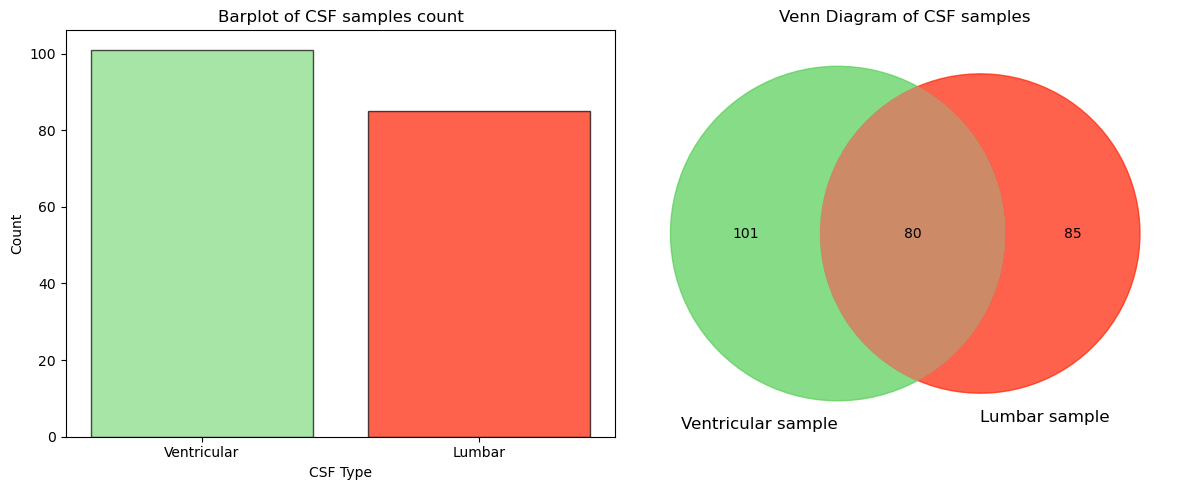

In [11]:
#--- TYPES OF SAMPLES BARPLOT AND VENN DIAGRAM ---#
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

#Barplot
value_counts = df_protein_median['CSF_type'].value_counts()

axs[0].bar(value_counts.index, value_counts, color=['#80DA80', '#FF2000'], edgecolor='black', alpha=0.7)
axs[0].set_xlabel('CSF Type')
axs[0].set_ylabel('Count')
axs[0].set_title('Barplot of CSF samples count')
axs[0].set_xticks([0, 1])
axs[0].set_xticklabels(['Ventricular', 'Lumbar'], rotation='horizontal')

#Venn Diagram
pers_id_with_V = set(df_protein_median[df_protein_median['CSF_type'] == 'V']['Sample_Run_ID'])
pers_id_with_L = set(df_protein_median[df_protein_median['CSF_type'] == 'L']['Sample_Run_ID'])

v = venn2(subsets=(len(pers_id_with_V), len(pers_id_with_L), len(pers_id_with_V & pers_id_with_L)),
      set_labels=('Ventricular sample', 'Lumbar sample'), ax=axs[1])
v.get_patch_by_id('10').set_color('#55CE55')
v.get_patch_by_id('10').set_alpha(0.7)
v.get_patch_by_id('01').set_color('#FF2000')
v.get_patch_by_id('01').set_alpha(0.7)
v.get_patch_by_id('11').set_color('#CC8A66')
v.get_patch_by_id('11').set_alpha(1)

axs[1].set_title('Venn Diagram of CSF samples')

plt.tight_layout()
plt.show()

This shows that we have slightly more ventricular samples compared to lumbar samples. The Venn diagram further tells us that we have both samples from 80 individuals, 21 ventricular-only samples and 5 lumbar-only samples. This totals to 186 samples. Considering the low amount of samples, splitting the dataset into ventricular and lumbar samples may be hard, but may give some information during the exploration phase.

# Exploration - Missingness

## Protein vs Peptide

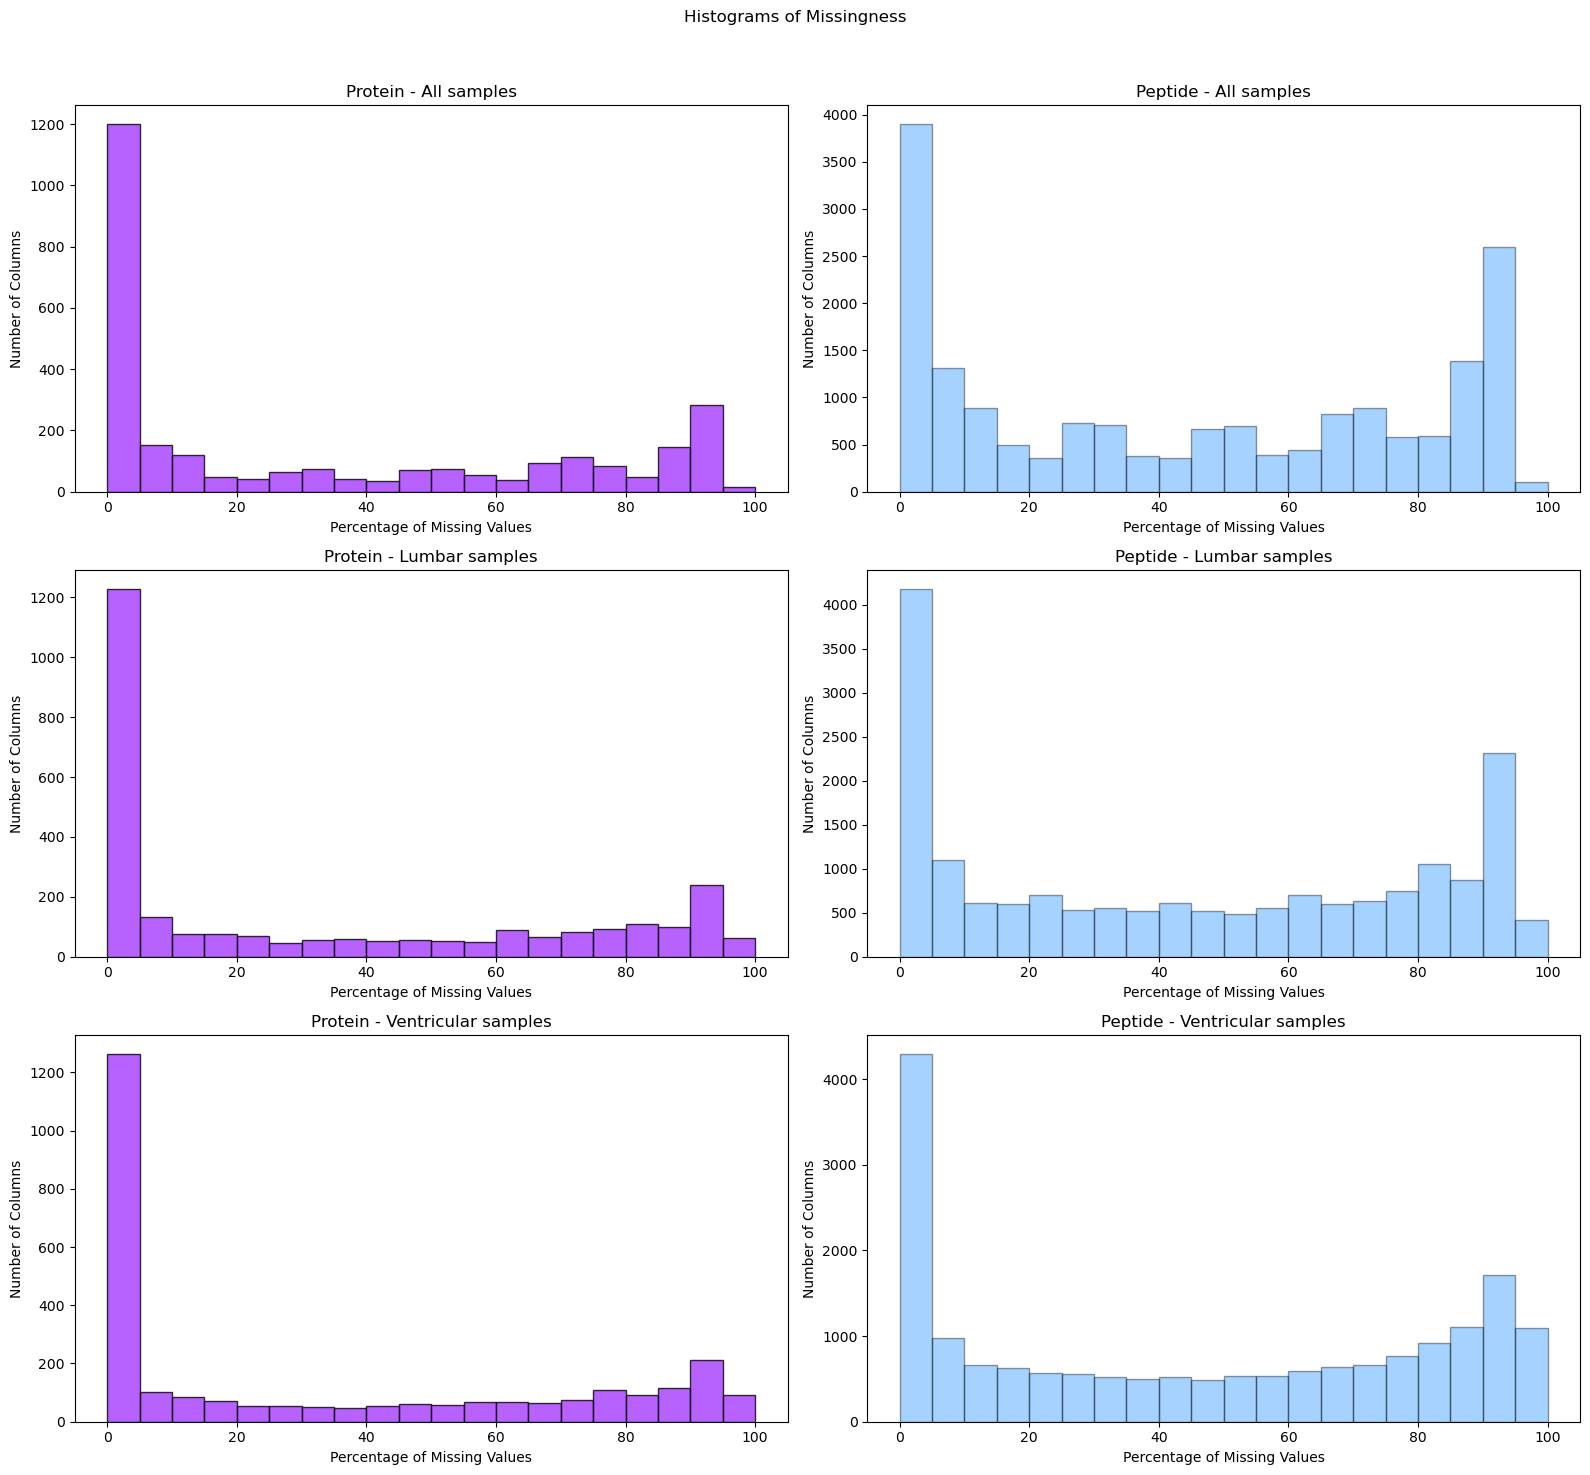

In [12]:
#Missingness histograms of all samples, lumbar and ventricular.
sample_types = [('All samples', protein_median, peptide_median),
                ('Lumbar samples', df_protein_median[df_protein_median['CSF_type'] == 'L'].iloc[:, 11:],
                 df_peptide_median[df_peptide_median['CSF_type'] == 'L'].iloc[:, 11:]),
                ('Ventricular samples', df_protein_median[df_protein_median['CSF_type'] == 'V'].iloc[:, 11:],
                 df_peptide_median[df_peptide_median['CSF_type'] == 'V'].iloc[:, 11:])]

fig, axes = plt.subplots(len(sample_types), 2, figsize=(16, 5 * len(sample_types)))
fig.suptitle('Histograms of Missingness')

for i, (sample_type, protein_data, peptide_data) in enumerate(sample_types):
    missingness_protein = (protein_data.isna().mean() * 100).round(2)
    missingness_peptide = (peptide_data.isna().mean() * 100).round(2)

    axes[i, 0].hist(missingness_protein, bins=np.arange(0, 101, 5), color='#a539ff', edgecolor='black', alpha=0.8)
    axes[i, 0].set_title(f'Protein - {sample_type}')
    axes[i, 0].set(xlabel='Percentage of Missing Values', ylabel='Number of Columns')

    axes[i, 1].hist(missingness_peptide, bins=np.arange(0, 101, 5), color='dodgerblue', edgecolor='black', alpha=0.4)
    axes[i, 1].set_title(f'Peptide - {sample_type}')
    axes[i, 1].set(xlabel='Percentage of Missing Values', ylabel='Number of Columns')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Overall, the peptide missingness is higher compared to the protein missingness. This is most likely due to each protein consisting of multiple peptides, so not only is the peptide dataset larger, the qualifications for finding a protein is easier than finding five peptides. This missingness seems to be consistent in both lumbar and ventricular samples. There are 2795 proteins and 18305 peptides, meaning there are roughly 6.5 peptides per protein in the datasets.

### Column value based missingness

In [13]:
#Getting missingness based on columns into dictionary.
cols = ["Sample_Run_ID", "TMT Set", "TMT Pos", "CSF_type", "Cortical_biopsy_grouping", "Gender", "Age_at_biopsy"]
sample = ["All samples", "Lumbar", "Ventricular"]

dict_missingness = {}
for col in cols:
    dict_missingness[f'{col}_Protein'] = get_missingness_based_on_column(df_protein_median, col)
    dict_missingness[f'{col}_Peptide'] = get_missingness_based_on_column(df_peptide_median, col)
    dict_missingness[f'{col}_Protein_Lumbar'] = get_missingness_based_on_column(df_protein_median[df_protein_median['CSF_type'] == 'L'], col)
    dict_missingness[f'{col}_Peptide_Lumbar'] = get_missingness_based_on_column(df_peptide_median[df_peptide_median['CSF_type'] == 'L'], col)
    dict_missingness[f'{col}_Protein_Ventricular'] = get_missingness_based_on_column(df_protein_median[df_protein_median['CSF_type'] == 'V'], col)
    dict_missingness[f'{col}_Peptide_Ventricular'] = get_missingness_based_on_column(df_peptide_median[df_peptide_median['CSF_type'] == 'V'], col)

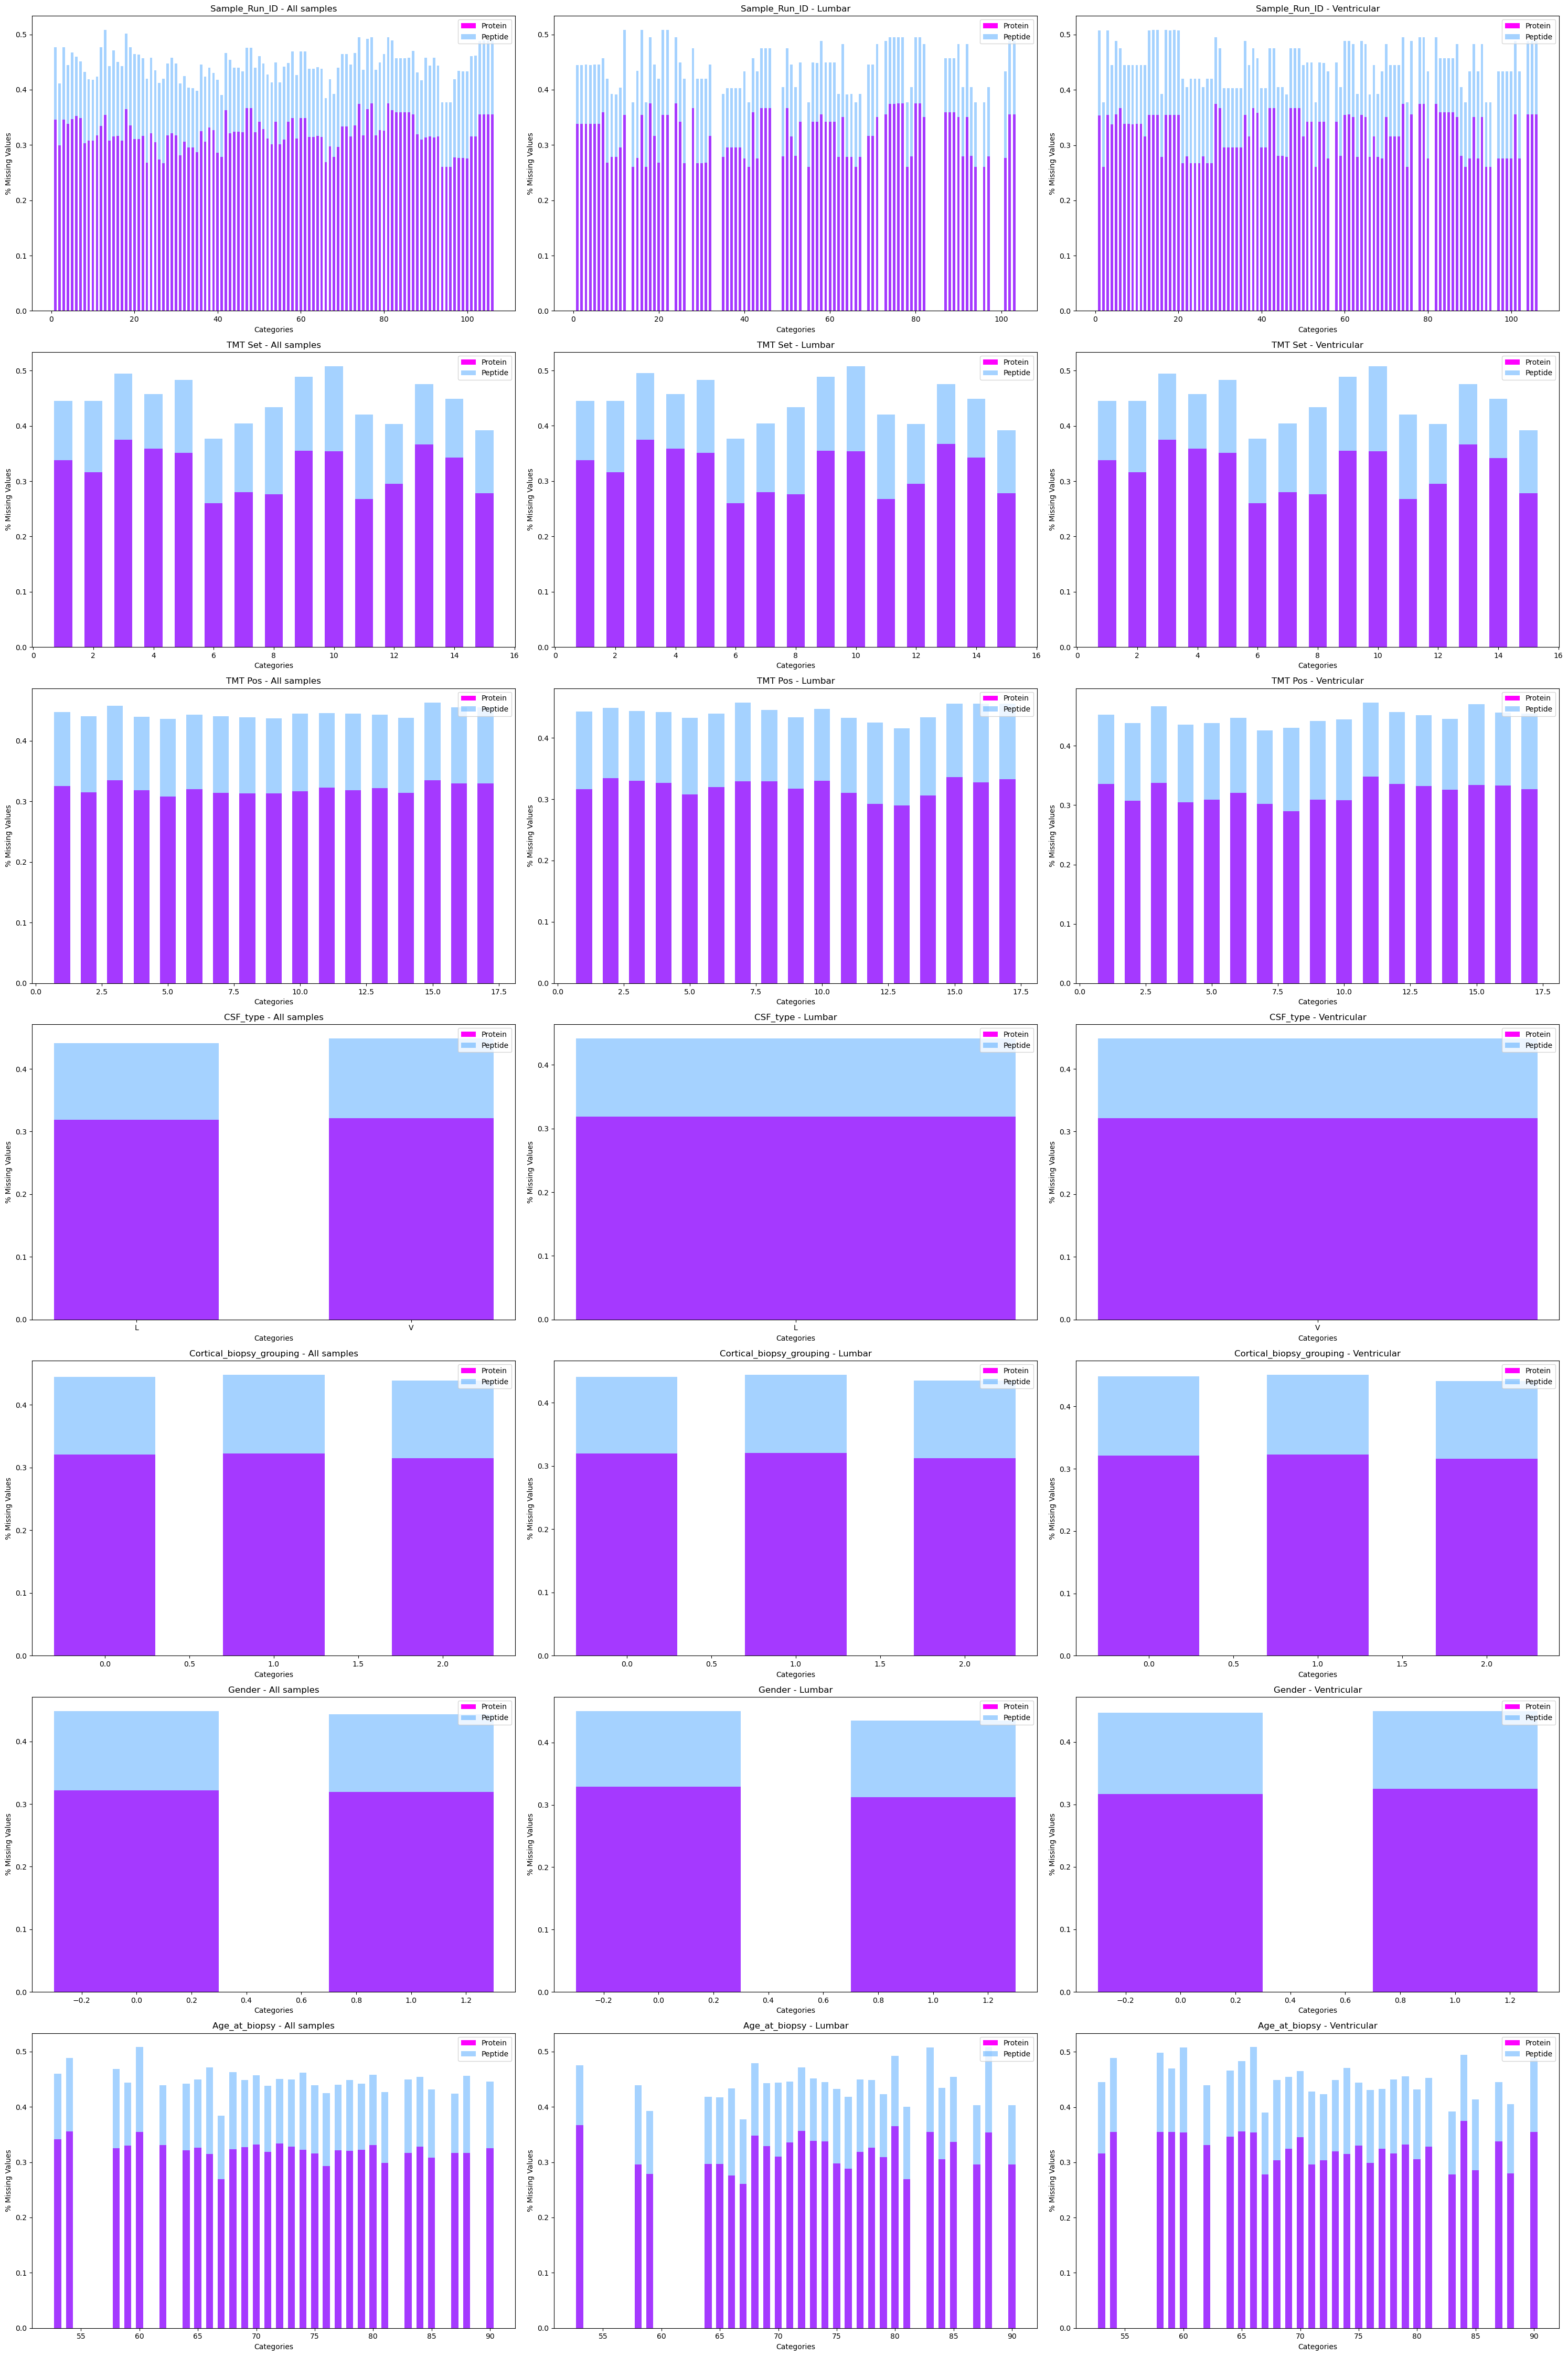

In [14]:
#--- PLOTTING BARCHARTS BASED OIN MISSINGNESS ---#
fig, axes = plt.subplots(7, 3, figsize=(30, 45))

for i in range(7):
    for j in range(3):
        dataset_name1, data1 = list(dict_missingness.items())[((i * 6) + (j * 2))]
        dataset_name2, data2 = list(dict_missingness.items())[((i * 6) + (j * 2) + 1)]
        values1 = list(data1.values())
        values2 = list(data2.values())

        categories = list(data1.keys())
        width = 0.6 

        axes[i, j].bar(categories, values1, width, color='magenta', label='Protein')
        axes[i, j].bar(categories, values2, width, color='dodgerblue', label='Peptide', alpha=0.4)

        axes[i, j].set_title(cols[i] + " - " + sample[j])
        axes[i, j].set_xlabel('Categories')
        axes[i, j].set_ylabel('% Missing Values')
        axes[i, j].legend(loc='upper right')

plt.tight_layout()
plt.show()

Overall, the missingness based on sample type (lumbar or ventricular) or structure type (protein or peptide) does not seem to have any particular correlation. Most of this missingness seems to be similar the groups, with peptide continuously having more missingness than proteins.  TMT Set seems to be the category that influenced the missingness the most.

In [135]:
import pandas as pd

def get_tmt_missingness_data(df_protein, df_peptide):
    """
    Get DataFrame with TMT based missingness data from protein and peptide dataset.

    :param df_protein: Protein dataframe.
    :param df_peptide: Peptide dataframe.
    :return: DataFrame with TMT based missingness data.
    """
    missing_values_per_row_pro = df_protein.iloc[:, 11:].isnull().sum(axis=1)
    missing_values_per_row_pep = df_peptide.iloc[:, 11:].isnull().sum(axis=1)

    new_df_pro = pd.DataFrame({
        'Sample_Run_ID': df_protein['Sample_Run_ID'],
        'TMT Set': df_protein['TMT Set'],
        'missing_values_per_row_pro': missing_values_per_row_pro
    })

    new_df_pep = pd.DataFrame({
        'missing_values_per_row_pep': missing_values_per_row_pep
    })

    missing_values_df = pd.merge(new_df_pep, new_df_pro, left_index=True, right_index=True)
    missing_values_df['dif'] = (missing_values_per_row_pro / len(df_protein.iloc[0])) / (missing_values_per_row_pep / len(df_peptide.iloc[0]))
    missing_values_df = missing_values_df.sort_values("TMT Set")
    c_order = ['Sample_Run_ID', 'TMT Set', 'missing_values_per_row_pro', 'missing_values_per_row_pep', 'dif']
    missing_values_df = missing_values_df[c_order]

    grouped_df = missing_values_df.groupby('TMT Set').agg({
        'Sample_Run_ID': list,
        'missing_values_per_row_pro': 'mean',
        'missing_values_per_row_pep': 'mean',
        'dif': 'mean',
        'missing_values_per_row_pro': ['min', 'max'],
        'missing_values_per_row_pep': ['min', 'max']
    }).reset_index()

    grouped_df['inconsistent_columns_pro'] = grouped_df['TMT Set'].apply(lambda tmt_set: find_inconsistent_columns(df_protein[df_protein['TMT Set'] == tmt_set].iloc[:, 11:]))
    grouped_df['nr_inc_pro'] = grouped_df['inconsistent_columns_pro'].apply(len)
    grouped_df['inconsistent_columns_pep'] = grouped_df['TMT Set'].apply(lambda tmt_set: find_inconsistent_columns(df_peptide[df_peptide['TMT Set'] == tmt_set].iloc[:, 11:]))
    grouped_df['nr_inc_pep'] = grouped_df['inconsistent_columns_pep'].apply(len)


    grouped_df.columns = ['_'.join(col).strip('_') for col in grouped_df.columns.values]

    return grouped_df


def find_inconsistent_columns(df):
    """
    Find columns where not all values are of the same type, considering NaN as a separate type.

    :param df: DataFrame.
    :return: List of column names where values are inconsistent in type.
    """
    inconsistent_columns = []

    for column in df.columns:
        column_values = df[column]
        unique_types = set(type(value) if not pd.isna(value) else np.nan for value in column_values)

        if len(unique_types) > 1:
            inconsistent_columns.append(column)

    return inconsistent_columns



In [136]:
tmt_data_df = get_tmt_missingness_data(df_protein_median, df_peptide_median)
tmt_data_df

,TMT Set,Sample_Run_ID_list,missing_values_per_row_pro_min,missing_values_per_row_pro_max,missing_values_per_row_pep_min,missing_values_per_row_pep_max,dif_mean,inconsistent_columns_pro,nr_inc_pro,inconsistent_columns_pep,nr_inc_pep
0,1,"[1, 4, 10, 9, 8, 7, 11, 5, 4, 3, 2, 6]",948,948,8147,8150,0.759382,[],0,"[P02768..37.65., P0DOY2..24.43...P0DOX8..134.1...",4
1,2,"[32, 73, 72, 12, 71, 51, 70, 37, 19, 50, 69, 67]",886,886,8154,8156,0.709174,[],0,"[Q96AC1..362.380., P01019..103.116., Q9Y371..3...",3
2,3,"[74, 80, 79, 24, 29, 78, 18, 77, 76, 75, 74, 8...",1051,1051,9064,9066,0.756820,[],0,"[P20774..166.181., P01019..421.437., P43121..4...",7
3,4,"[83, 84, 85, 42, 86, 39, 87, 88, 7, 89]",1007,1007,8369,8376,0.784917,[],0,"[Q8IX30..165.173., Q96AC1..362.380., Q8WXD2..3...",10
4,5,"[91, 70, 87, 93, 63, 92, 90, 82, 65, 62, 71]",984,984,8839,8842,0.726524,[],0,"[P01019..421.437., Q92859..239.253., P36955..7...",6
5,6,"[94, 89, 78, 94, 53, 17, 14, 66, 95, 75, 41, 9...",730,730,6904,6909,0.689934,[],0,"[P34096..39.51., Q8IX30..165.173., P43121..480...",9
6,7,"[49, 91, 59, 44, 26, 45, 22, 79, 93, 88, 52, 97]",785,785,7403,7416,0.691449,[],0,"[P04264..418.432., P04114..4188.4201., Q6E0U4....",19
7,8,"[101, 80, 99, 56, 102, 40, 43, 15, 100, 92, 69...",774,774,7939,7944,0.636182,[],0,"[P35579..1052.1075., P04114..3847.3868., Q9285...",9
8,9,"[101, 64, 5, 60, 105, 73, 61, 58, 103, 102, 10...",996,996,8943,8953,0.726458,[],0,"[Q9BUD6..155.175., Q6UWR7..159.178., Q9Y287..1...",16
9,10,"[12, 21, 20, 3, 19, 18, 22, 16, 15, 14, 13, 17...",993,993,9298,9310,0.696692,[],0,"[P63010..345.359...Q10567..345.359., A6NLU5..1...",26


(In the above graph, high dif_mean means that, comparatively, either more peptides were found or less proteins were found. The difference of dif_mean between the sets means that the ratio of found peptides / proteins differ.)

This is missingness data based on the grouping of the TMT Sets. This is a basic and overarching way of looking at the batch effect. It seems that in each TMT Set, the number of proteins discored seems to be differing by 1 value between the individuals in the set, while in the peptide set, this value is between 4 and 18. Further, there seems to be a big difference in the protein vs peptide missingness in each TMT Set. On average, the proteins have a missingness of 72% of that of the peptides in each TMT Set, but this value goes as low as 63% and as high as 78%. Following this, some TMT Sets have a lot more missingness compared to others. All of this seems to suggest that a "good TMT Set" does not necessarily result in good results for both proteins and peptides.

# Exploration - PCA

In [17]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [18]:
def do_scree_plot_data(pca):
    """
    Gets Scree Plot Data from a PCA.

    :param pca: PCA already fit and processed.
    :return: PCA Scree Plot Data.
    """ 
    pca_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
    pca_labels = ['PC' + str(x) for x in range(1, len(pca_var)+1)]
    return (pca_var, pca_labels)

In [19]:
def do_PCA_on_DF(df, n_components=10):
    """
    Does PCA on a DF.

    :param df: Dataframe-base to perform PCA on.
    :param n_components: Number of PCA components to find.
    :return: PCA Scree Plot Data.
    """ 
    df_clean = set_max_missingness_per_column(df, 0)
    scaler = StandardScaler()
    df_standardized = scaler.fit_transform(df_clean)
    pca = PCA(n_components=n_components)
    pca.fit(df_standardized)
    
    return do_scree_plot_data(pca)

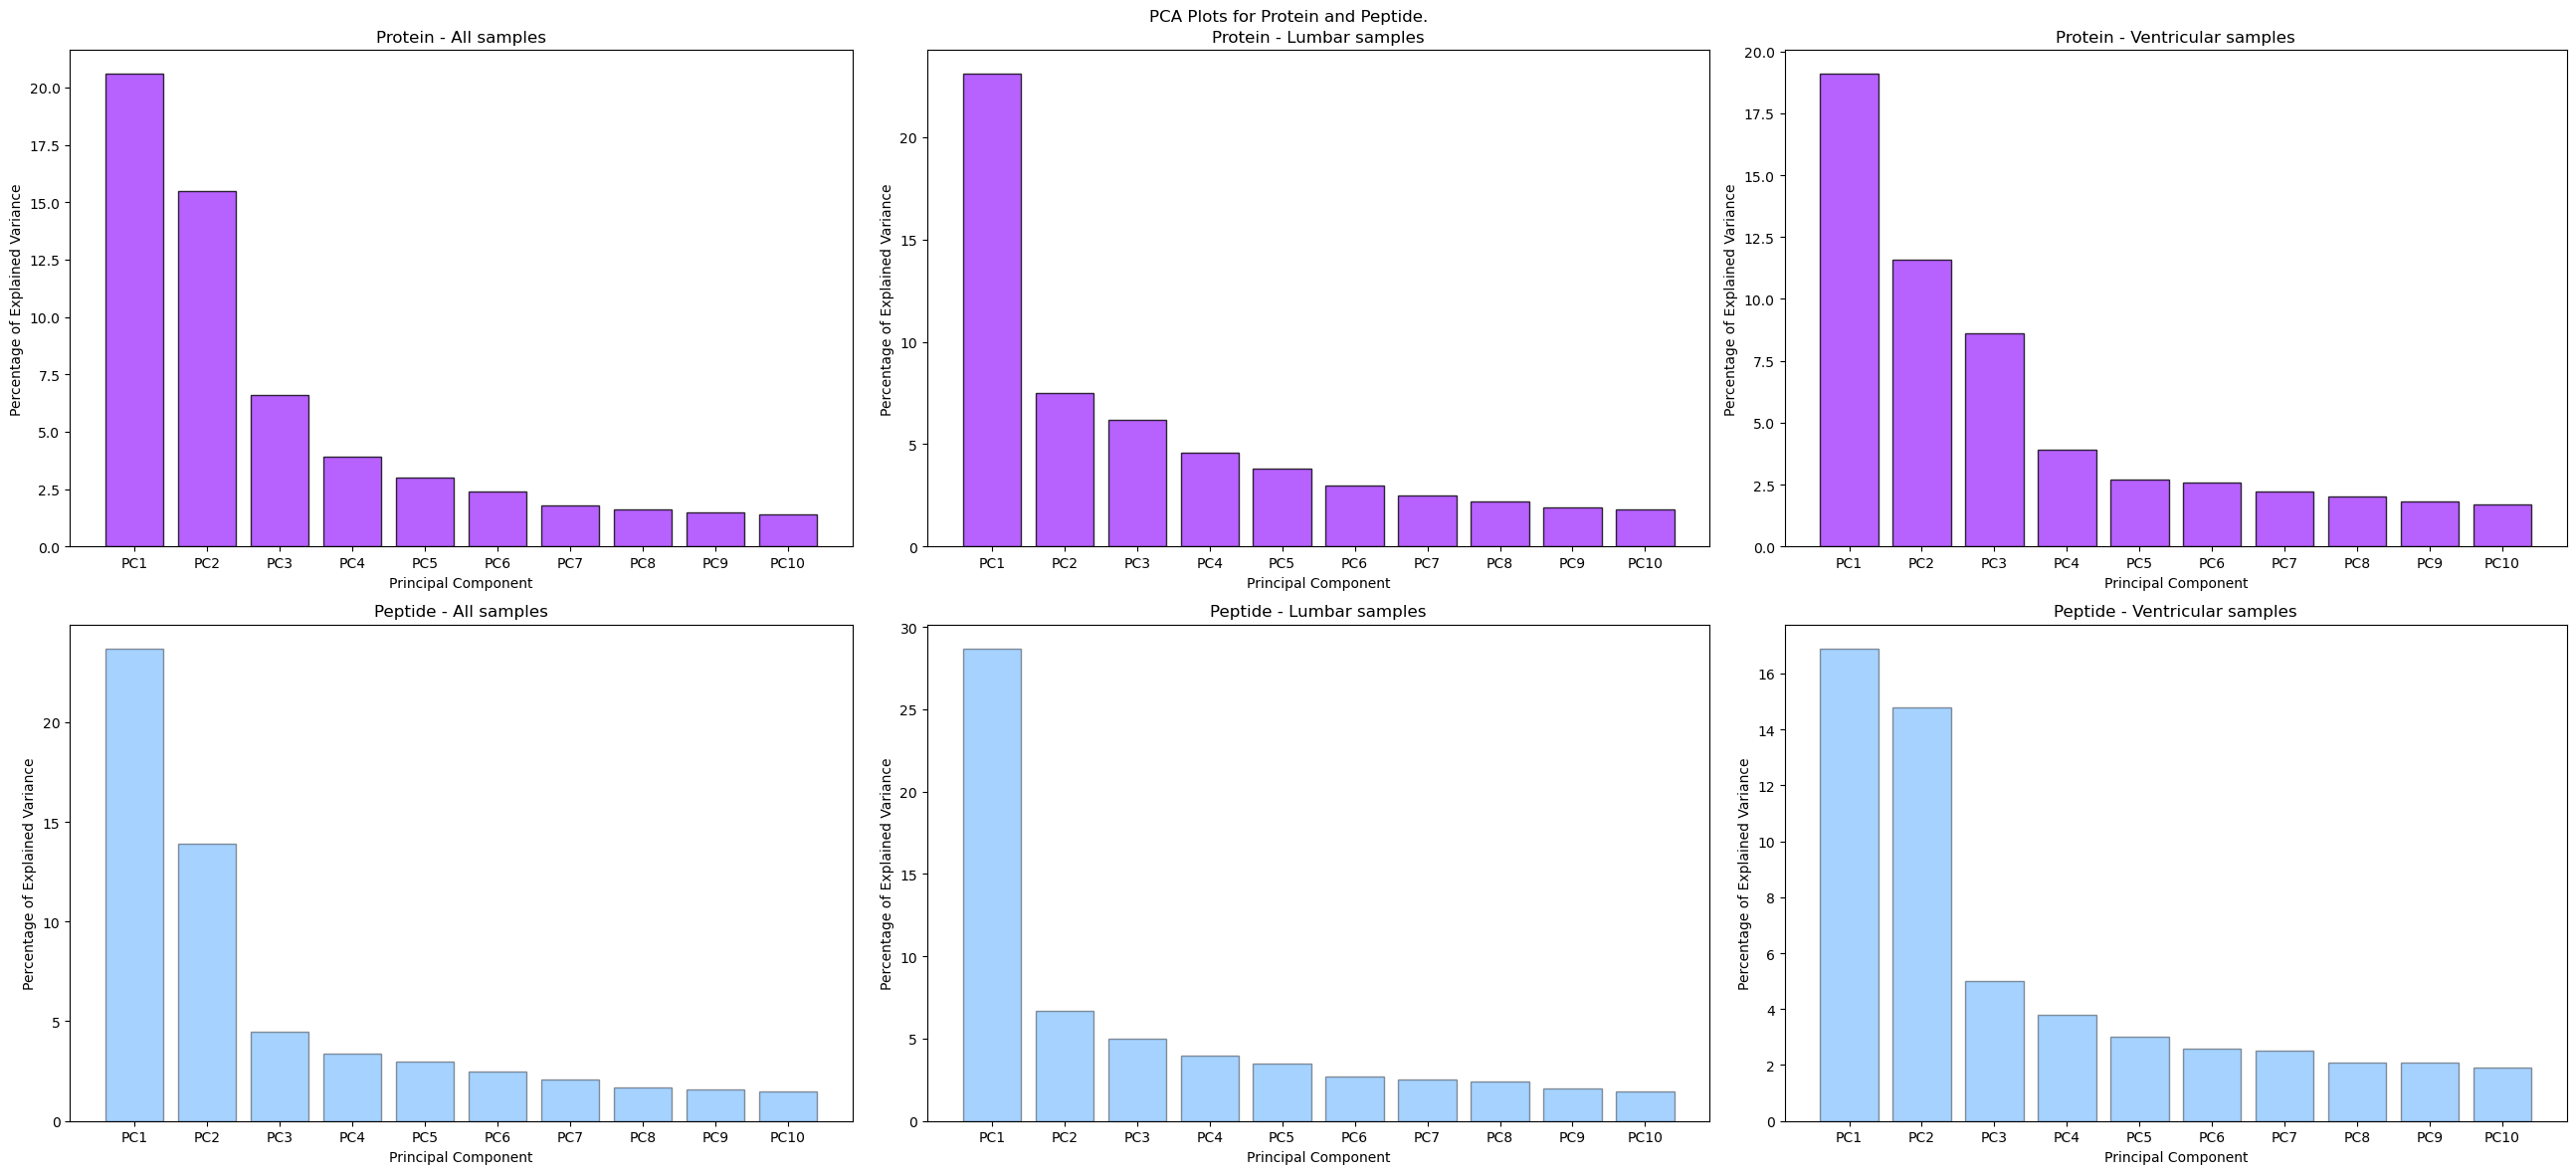

In [20]:
#--- RUNNING PCA CALCULATION AND PLOTTING ---#
datasets_protein = [protein_median, df_protein_median[df_protein_median['CSF_type'] == 'L'].iloc[:, 11:],
                    df_protein_median[df_protein_median['CSF_type'] == 'V'].iloc[:, 11:]]
labels_protein = ['Protein - All samples', 'Protein - Lumbar samples', 'Protein - Ventricular samples']

datasets_peptide = [peptide_median, df_peptide_median[df_peptide_median['CSF_type'] == 'L'].iloc[:, 11:],
                     df_peptide_median[df_peptide_median['CSF_type'] == 'V'].iloc[:, 11:]]
labels_peptide = ['Peptide - All samples', 'Peptide - Lumbar samples', 'Peptide - Ventricular samples']

fig, axes = plt.subplots(2, 3, figsize=(26, 12))
fig.suptitle('PCA Plots for Protein and Peptide.')

for i, (dataset_protein, label_protein, dataset_peptide, label_peptide) in enumerate(
        zip(datasets_protein, labels_protein, datasets_peptide, labels_peptide)):
    #Protein
    var_protein, labels_protein = do_PCA_on_DF(dataset_protein)
    axes[0, i].bar(x=range(1, len(var_protein) + 1), height=var_protein,
                   tick_label=labels_protein,
                   color='#a539ff', edgecolor='black', alpha=0.8)
    axes[0, i].set_ylabel('Percentage of Explained Variance')
    axes[0, i].set_xlabel('Principal Component')
    axes[0, i].set_title(label_protein)

    #Peptide
    var_peptide, labels_peptide = do_PCA_on_DF(dataset_peptide)
    axes[1, i].bar(x=range(1, len(var_peptide) + 1), height=var_peptide,
                   tick_label=labels_peptide,
                   color='dodgerblue', edgecolor='black', alpha=0.4)
    axes[1, i].set_ylabel('Percentage of Explained Variance')
    axes[1, i].set_xlabel('Principal Component')
    axes[1, i].set_title(label_peptide)

plt.tight_layout()
plt.show()

The PCA graphs show that all samples and variations of some form of higher importance in PC1 (and in some cases PC2), which is expected. However, the overall strenght of PC1 + PC2 is not enough in either sample-set to visualize it and get a good correlation matrix. The best result (Peptide - All samples) seem to have around 40% correlation from the first to PCA's. A good matrix would be having at least 70% correlation. This suggest that the current datasets, where features are being removed if they contain any form of missingness, is not ideal in order to distinguish individual samples based on only 2 dimensions.

# Exploration - t-SNE

## Cortical_biopsy_grouping

In [21]:
from sklearn.manifold import TSNE

In [22]:
def do_tSNE_on_DF(df, feature, lr=100, n_components=2):
    """
    Gets t-SNE data from DF.

    :param df: Dataframe to perform t-SNE on.
    :param lr: Learning rate of TSNE calculation.
    :param n_components: Number of t-SNE components to find.
    :return: t-SNE results in DF.
    """ 
    df_clean = set_max_missingness_per_column(df.iloc[:,11:], 0)
    scaler = StandardScaler()
    df_tsne = scaler.fit_transform(df_clean)
    tsne = TSNE(learning_rate=lr, n_components=n_components, random_state=42)
    tsne_features = tsne.fit_transform(df_tsne)

    df_done = pd.DataFrame({'x':tsne_features[:,0], 'y':tsne_features[:,1], feature: df[feature]})
    df_done = df_done.sort_values(by=feature)
    return df_done

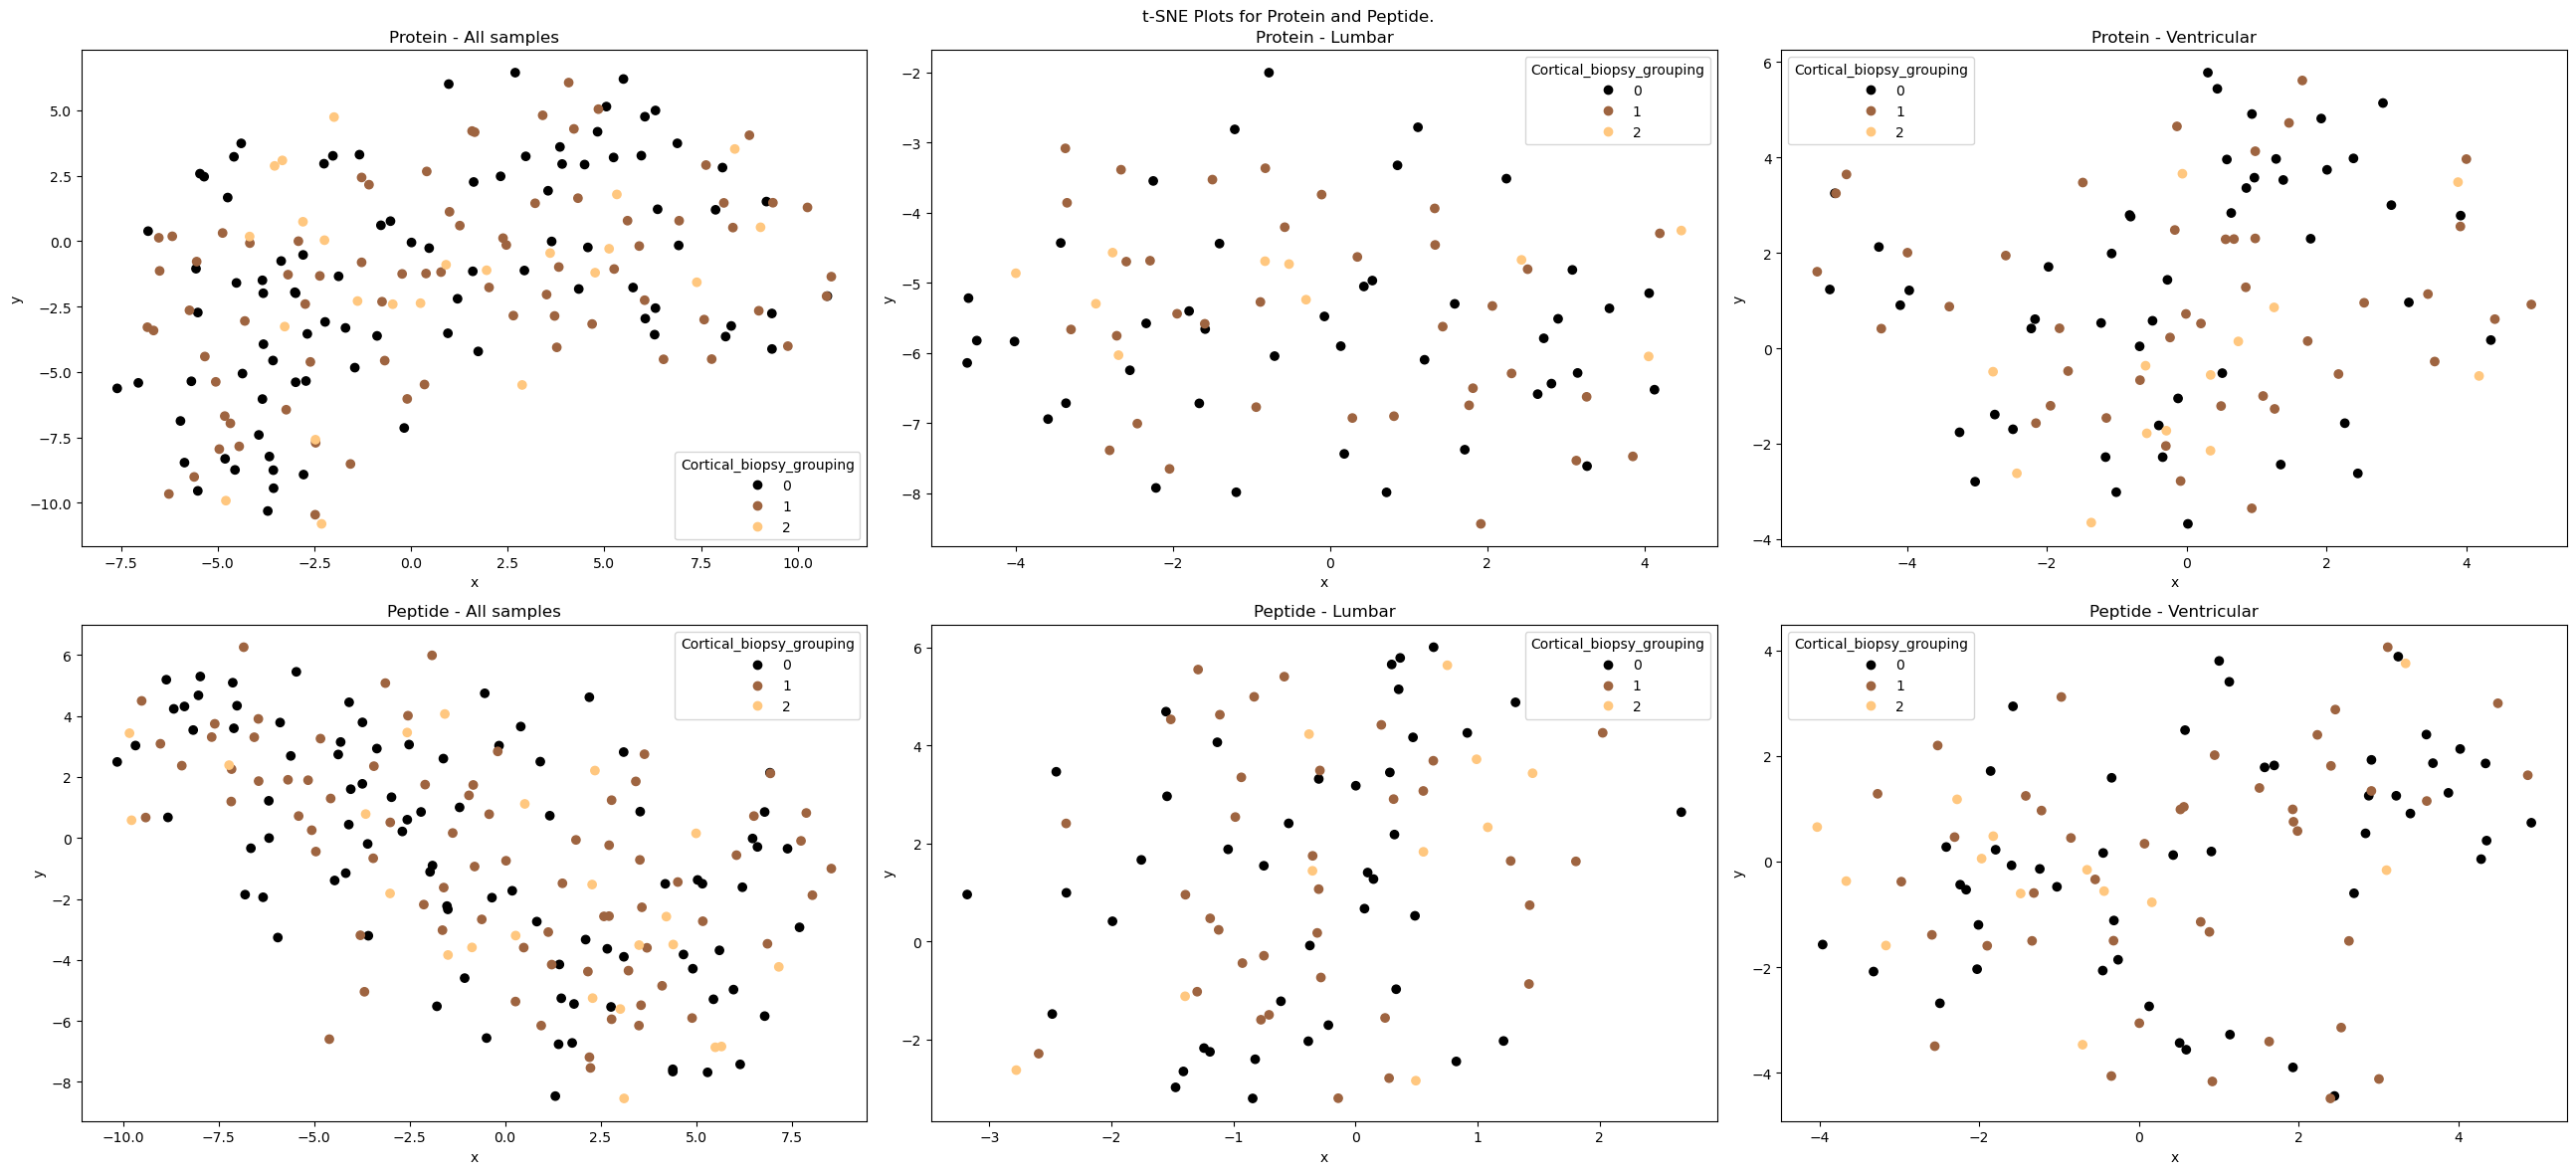

In [23]:
#--- RUNNING t-SNE CALCULATION AND PLOTTING ---#
all_pro_result_df = do_tSNE_on_DF(df_protein_median,"Cortical_biopsy_grouping")
all_pep_result_df = do_tSNE_on_DF(df_peptide_median,"Cortical_biopsy_grouping")
l_pro_result_df = do_tSNE_on_DF(df_protein_median[df_protein_median['CSF_type'] == 'L'],"Cortical_biopsy_grouping")
l_pep_result_df = do_tSNE_on_DF(df_peptide_median[df_peptide_median['CSF_type'] == 'L'],"Cortical_biopsy_grouping")
v_pro_result_df = do_tSNE_on_DF(df_protein_median[df_protein_median['CSF_type'] == 'V'],"Cortical_biopsy_grouping")
v_pep_result_df = do_tSNE_on_DF(df_peptide_median[df_peptide_median['CSF_type'] == 'V'],"Cortical_biopsy_grouping")

types = ['All samples', 'Lumbar', 'Ventricular']
protein_dfs = [all_pro_result_df, l_pro_result_df, v_pro_result_df]
peptide_dfs = [all_pep_result_df, l_pep_result_df, v_pep_result_df]

fig, axes = plt.subplots(2, 3, figsize=(26, 12))
fig.suptitle('t-SNE Plots for Protein and Peptide.')

for i, (protein_df, peptide_df) in enumerate(zip(protein_dfs, peptide_dfs)):
    #Protein
    scatter_protein = axes[0, i].scatter(x=protein_df["x"], y=protein_df["y"], cmap='copper', 
                                       c=protein_df["Cortical_biopsy_grouping"])
    legend_labels_protein = protein_df["Cortical_biopsy_grouping"].unique()
    axes[0, i].legend(scatter_protein.legend_elements()[0], legend_labels_protein, title='Cortical_biopsy_grouping')
    axes[0, i].set_xlabel("x")
    axes[0, i].set_ylabel("y")
    axes[0, i].set_title(f'Protein - {types[i]}')

    #Peptide
    scatter_peptide = axes[1, i].scatter(x=peptide_df["x"], y=peptide_df["y"], cmap='copper', 
                                       c=peptide_df["Cortical_biopsy_grouping"])
    legend_labels_peptide = peptide_df["Cortical_biopsy_grouping"].unique()
    axes[1, i].legend(scatter_peptide.legend_elements()[0], legend_labels_peptide, title='Cortical_biopsy_grouping')
    axes[1, i].set_xlabel("x")
    axes[1, i].set_ylabel("y")
    axes[1, i].set_title(f'Peptide - {types[i]}')

plt.tight_layout()
plt.show()

This further shows that there is no real correlation in order to classify the data based on only 2 dimensions. This seems to be true for all sample-sets (all, lumbar, ventricular).

## TMT Set

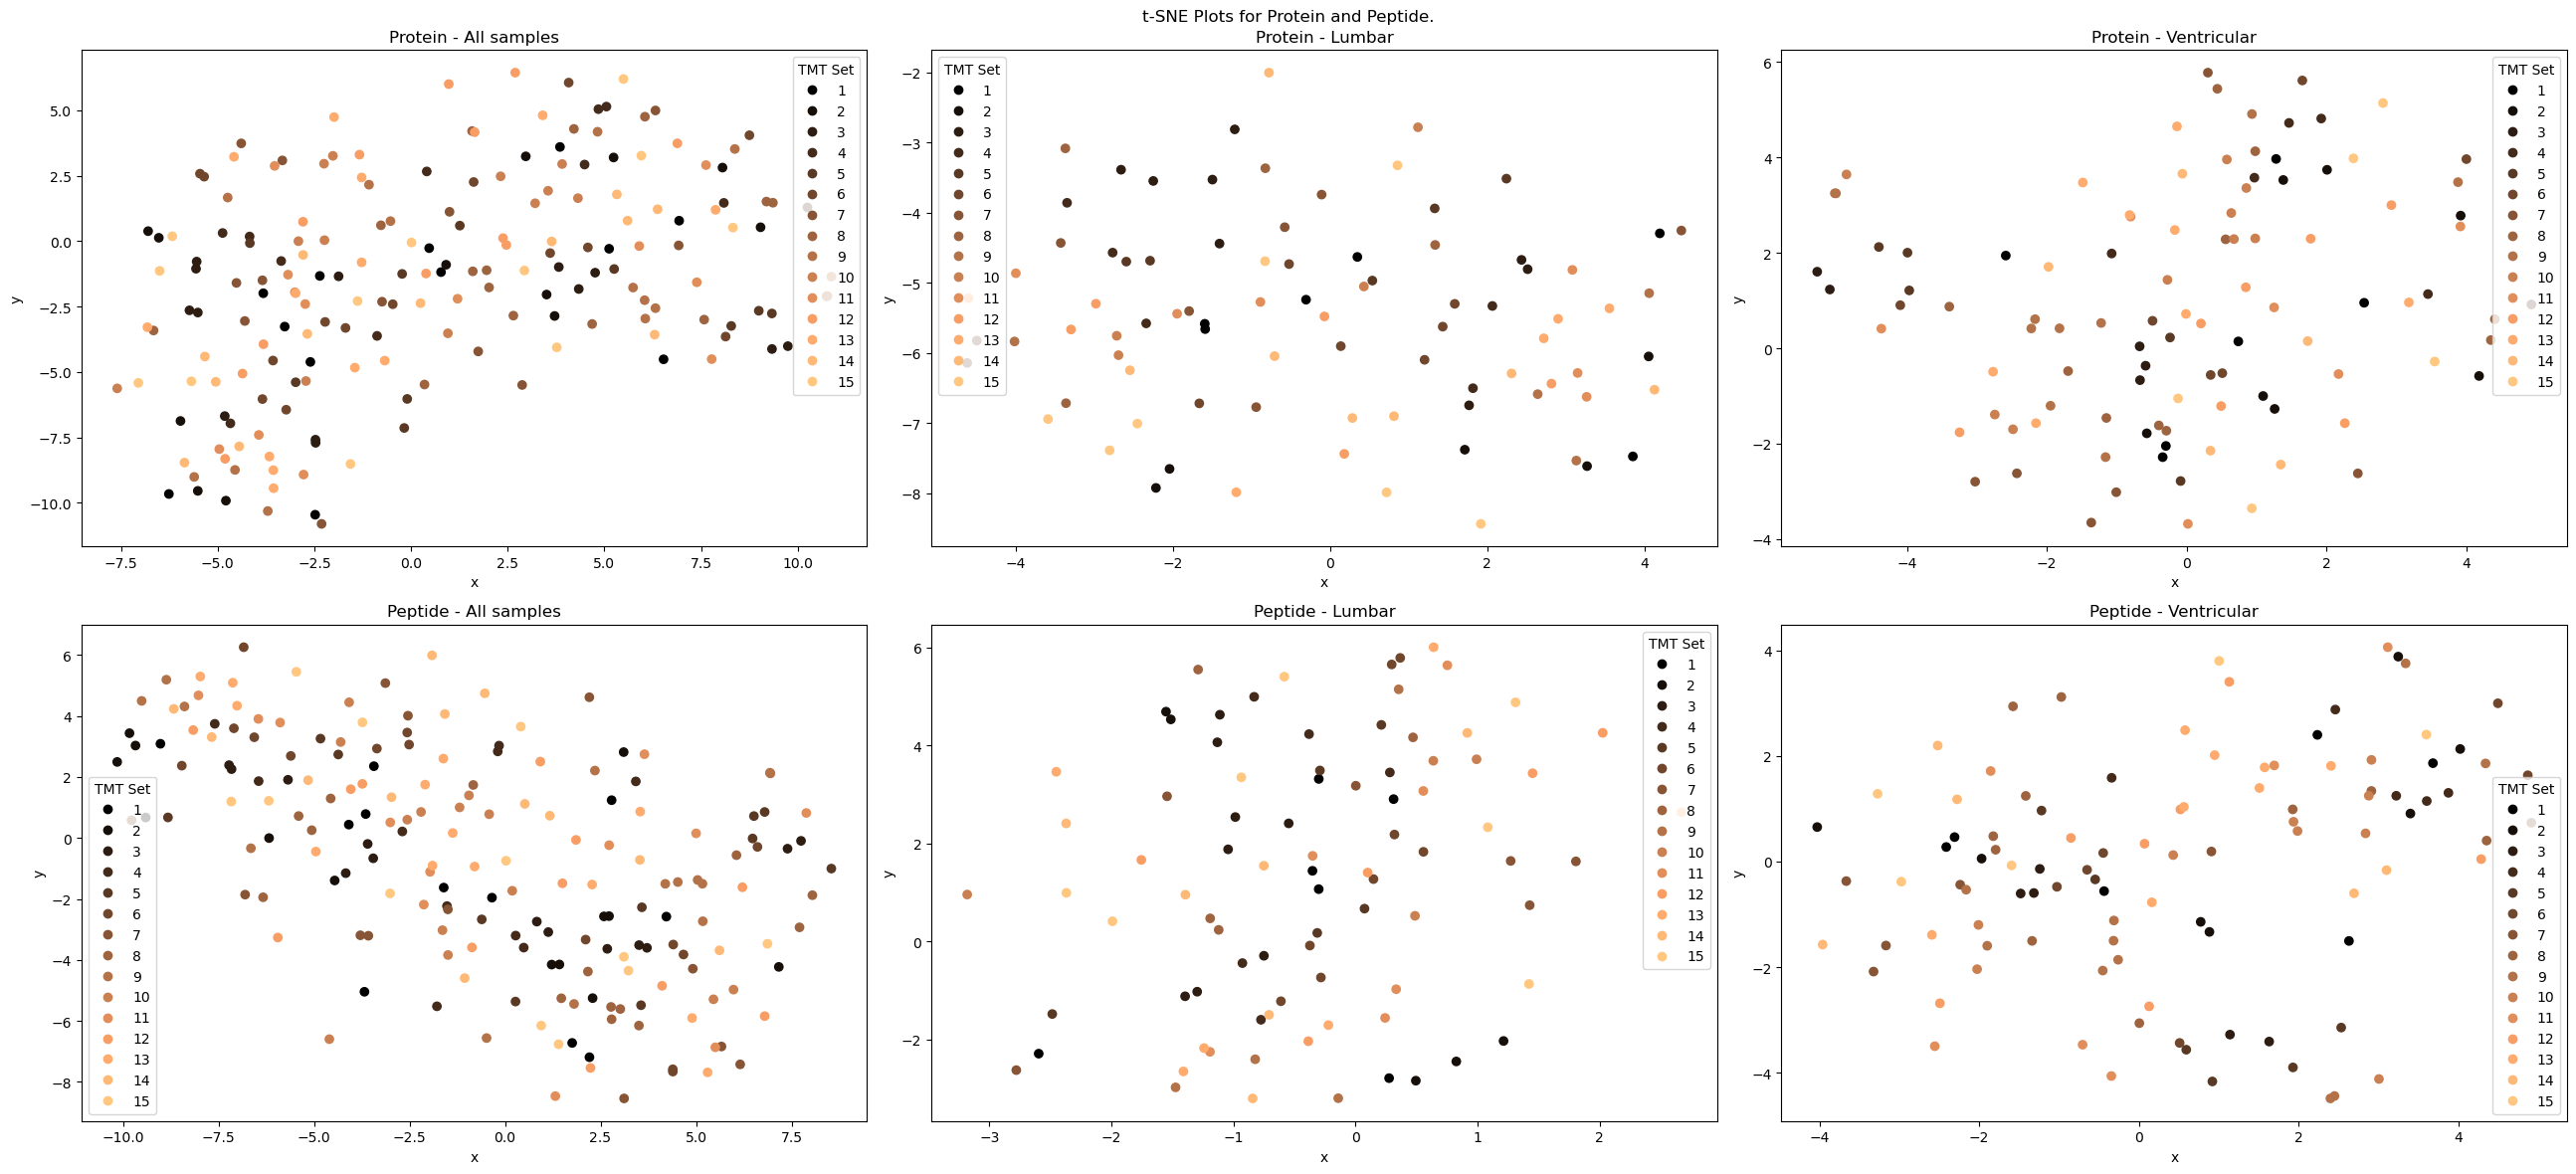

In [24]:
#--- RUNNING t-SNE CALCULATION AND PLOTTING ---#
all_pro_result_df = do_tSNE_on_DF(df_protein_median,"TMT Set")
all_pep_result_df = do_tSNE_on_DF(df_peptide_median,"TMT Set")
l_pro_result_df = do_tSNE_on_DF(df_protein_median[df_protein_median['CSF_type'] == 'L'],"TMT Set")
l_pep_result_df = do_tSNE_on_DF(df_peptide_median[df_peptide_median['CSF_type'] == 'L'],"TMT Set")
v_pro_result_df = do_tSNE_on_DF(df_protein_median[df_protein_median['CSF_type'] == 'V'],"TMT Set")
v_pep_result_df = do_tSNE_on_DF(df_peptide_median[df_peptide_median['CSF_type'] == 'V'],"TMT Set")

types = ['All samples', 'Lumbar', 'Ventricular']
protein_dfs = [all_pro_result_df, l_pro_result_df, v_pro_result_df]
peptide_dfs = [all_pep_result_df, l_pep_result_df, v_pep_result_df]

fig, axes = plt.subplots(2, 3, figsize=(26, 12))
fig.suptitle('t-SNE Plots for Protein and Peptide.')

for i, (protein_df, peptide_df) in enumerate(zip(protein_dfs, peptide_dfs)):
    #Protein
    scatter_protein = axes[0, i].scatter(x=protein_df["x"], y=protein_df["y"], cmap='copper', 
                                       c=protein_df["TMT Set"])
    legend_labels_protein = protein_df["TMT Set"].unique()
    axes[0, i].legend(scatter_protein.legend_elements()[0], legend_labels_protein, title='TMT Set')
    axes[0, i].set_xlabel("x")
    axes[0, i].set_ylabel("y")
    axes[0, i].set_title(f'Protein - {types[i]}')

    #Peptide
    scatter_peptide = axes[1, i].scatter(x=peptide_df["x"], y=peptide_df["y"], cmap='copper', 
                                       c=peptide_df["TMT Set"])
    legend_labels_peptide = peptide_df["TMT Set"].unique()
    axes[1, i].legend(scatter_peptide.legend_elements()[0], legend_labels_peptide, title='TMT Set')
    axes[1, i].set_xlabel("x")
    axes[1, i].set_ylabel("y")
    axes[1, i].set_title(f'Peptide - {types[i]}')

plt.tight_layout()
plt.show()

This further shows that there is no real correlation between the TMT Sets when looking at only 2 dimensions on data where missingness features are removed. In one way, this is good because it shows that there is no real batch effect when removing these features. As can be seen further down, this does not hold true when imputing missingness with zero.

# Feature Importance

## Random Forest

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [26]:
def random_forest_feature_extraction(df, y, num_runs = 100, num_trees = 100):
    """
    Extracts features through random forest from a df.

    :param df: Dataframe to extract features from.
    :param y: Predictor class in dataframe.
    :param num_runs: Number of iterations to create a random forest classifier.
    :param num_trees: Hyperparameter setting for each random forest classifier.
    :return: The features extracted in a pandas series.
    """ 
    X = set_max_missingness_per_column(df.iloc[:,11:], 0)
    y = df[y]

    all_feature_importances_list = [0] * len(X.columns)

    for run in range(num_runs):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
        rf_classifier = RandomForestClassifier(n_estimators=num_trees, random_state=run)
        rf_classifier.fit(X_train, y_train)
        all_feature_importances_list = [x+y for x,y in zip(all_feature_importances_list, rf_classifier.feature_importances_)]

    feature_importances_series = pd.Series(all_feature_importances_list, index=X.columns)
    feature_importances_series /= 100
    feature_importances_series = feature_importances_series.sort_values(ascending=False)
    
    return feature_importances_series

In [27]:
def visualize_top_features(importances1, importances2=None, top_n=10, samples="All samples"):
    """
    Visualize feature importance in barchart(s) from pandas series.

    :param importances1: Pandas series with feature importances.
    :param importances2: Pandas series with feature importances.
    :param top_n: How many features that should be visualized.
    """ 
    if importances2 is not None:
        top_features1 = importances1.head(top_n)
        top_features2 = importances2.head(top_n)

        fig, axes = plt.subplots(1, 2, figsize=(20, (top_n/4)))

        axes[0].barh(top_features1.index, top_features1.values)
        axes[0].set_xlabel('Importance')
        axes[0].set_title(f'Top {top_n} Feature Importance - Protein - {samples}')

        axes[1].barh(top_features2.index, top_features2.values)
        axes[1].set_xlabel('Importance')
        axes[1].set_title(f'Top {top_n} Feature Importance - Peptide - {samples}')

        plt.tight_layout()
        plt.show()

    else:
        top_features = importances1.head(top_n)

        plt.figure(figsize=(10, top_n/5))
        plt.barh(top_features.index, top_features.values)
        plt.xlabel('Importance')
        plt.title(f'Top {top_n} Feature Importance')
        plt.show()

In [28]:
def get_feature_importance_df(series_lumbar, series_ventricular):
    """
    Creates a df based on feature importance, comparing lumbar and ventricular data.

    :param series_lumbar: Pandas series with feature importances.
    :param series_ventricular: Pandas series with feature importances.
    :param df_merged: Dataframe with feature importance of both lumbar and ventricular data.
    """ 
    df_lumbar = pd.DataFrame(series_lumbar)
    df_ventricular = pd.DataFrame(series_ventricular)

    df_merged = pd.merge(df_lumbar, df_ventricular, left_index=True, right_index=True, how='outer')
    df_merged = df_merged.rename(columns={'0_x':'Lumbar', '0_y':'Ventricular'})
    return df_merged

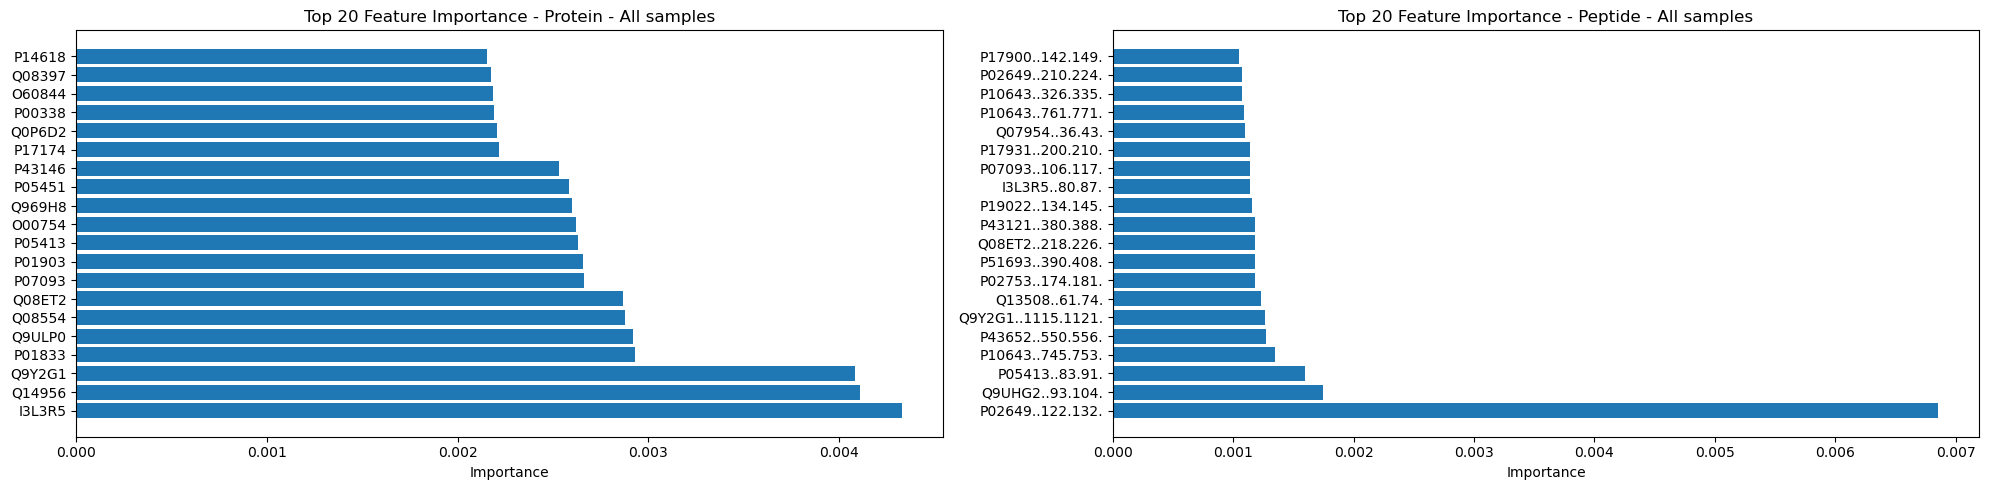

In [29]:
#--- RUNNING RANDOM FOREST FEATURE IMPORTANCE EXTRACTION AND PLOTTING - ALL SAMPLES ---#
protein_features_all = random_forest_feature_extraction(df_protein_median, "Cortical_biopsy_grouping", 100)
peptide_features_all = random_forest_feature_extraction(df_peptide_median, "Cortical_biopsy_grouping", 100)

visualize_top_features(protein_features_all, peptide_features_all, 20)

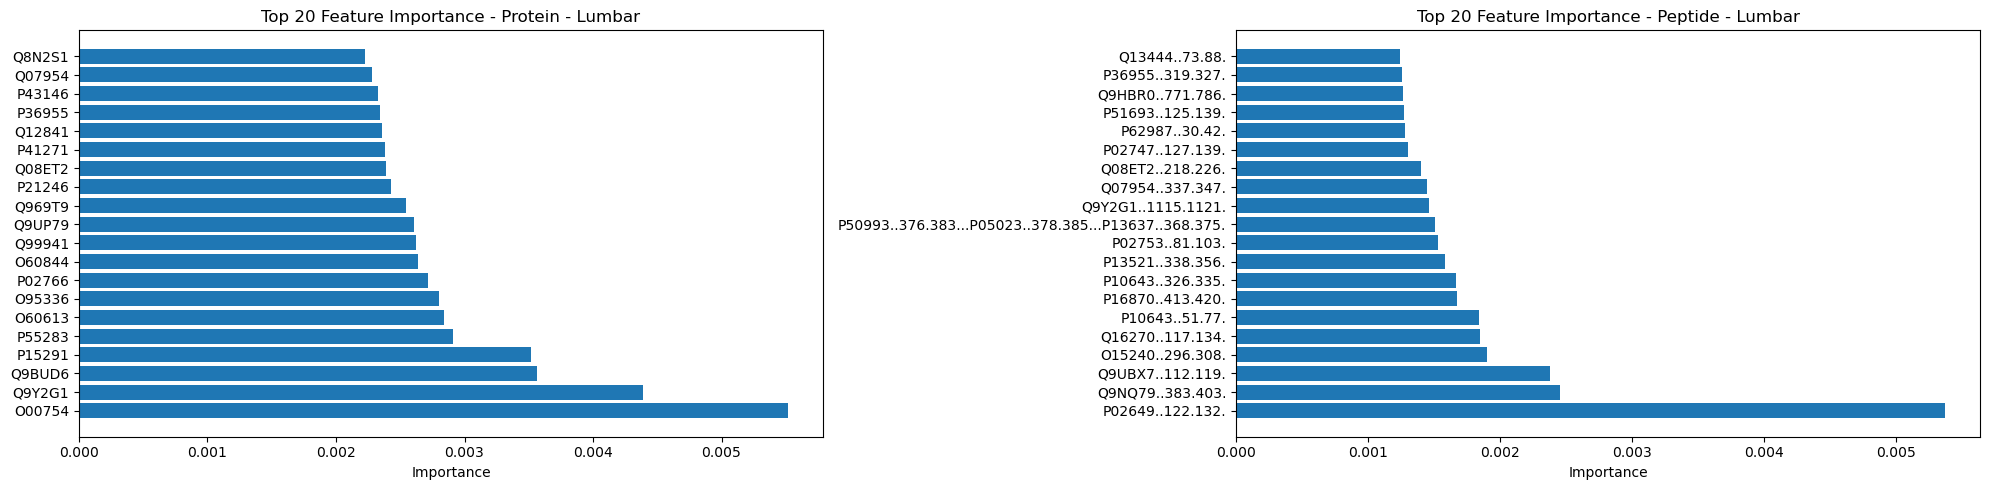

In [30]:
#--- RUNNING RANDOM FOREST FEATURE IMPORTANCE EXTRACTION AND PLOTTING - LUMBAR ---#
protein_features_l = random_forest_feature_extraction(df_protein_median[df_protein_median['CSF_type'] == 'L'], "Cortical_biopsy_grouping", 100)
peptide_features_l = random_forest_feature_extraction(df_peptide_median[df_peptide_median['CSF_type'] == 'L'], "Cortical_biopsy_grouping", 100)

visualize_top_features(protein_features_l, peptide_features_l, 20, "Lumbar")

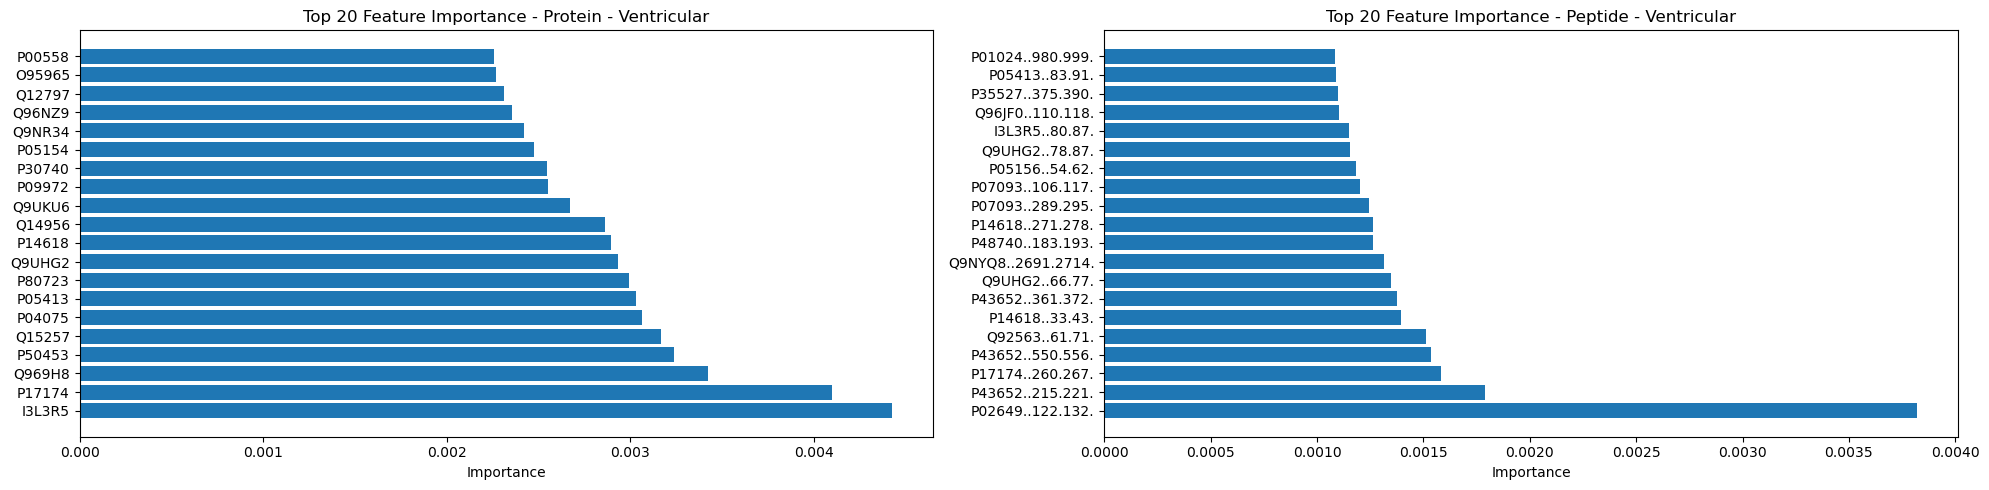

In [31]:
#--- RUNNING RANDOM FOREST FEATURE IMPORTANCE EXTRACTION AND PLOTTING - VENTRICULAR ---#
protein_features_v = random_forest_feature_extraction(df_protein_median[df_protein_median['CSF_type'] == 'V'], "Cortical_biopsy_grouping", 100)
peptide_features_v = random_forest_feature_extraction(df_peptide_median[df_peptide_median['CSF_type'] == 'V'], "Cortical_biopsy_grouping", 100)

visualize_top_features(protein_features_v, peptide_features_v, 20, "Ventricular")

This is just a very simplified feature extraction through a basic random forest model. This data is based on only features without missingness, but even here, we can see that some features are strong in both samples (especially in the peptide set), while the protein set does not seem to have any common proteins in the top 20 proteins from the lumbar and ventricular set. The all samples set, however, contains proteins from both the top lumbar and ventricular set, suggesting that even if they are not in the top 20, they do exist. This is more of a proof of concept rather than "finding the best features", and hints that, especially when looking at proteins, there are different proteins that should be looked at depending on if it is a lumbar sample or a ventricular sample.

In [32]:
#This function creates a df in order to compare the feature importance of lumbar and ventricular series.
get_feature_importance_df(protein_features_l, protein_features_v)

,Lumbar,Ventricular
A0A075B6I0,0.000675,0.000710
A0A075B6I1,0.001117,0.000992
A0A075B6I9,0.000696,0.000841
A0A075B6K0,0.000571,0.000571
A0A075B6K4,0.000620,0.000617
...,...,...
Q9Y6N6,0.001658,0.000825
Q9Y6N7,0.000474,0.000751
Q9Y6N8,0.000853,0.000537
Q9Y6R7,0.000777,0.000704


# Testing with 0 (not NaN)

## PCA

In [33]:
zero_protein_df = df_protein_median.copy(deep=True)
zero_protein_df = replace_nan_with_zero(zero_protein_df)

zero_peptide_df = df_peptide_median.copy(deep=True)
zero_peptide_df = replace_nan_with_zero(zero_peptide_df)

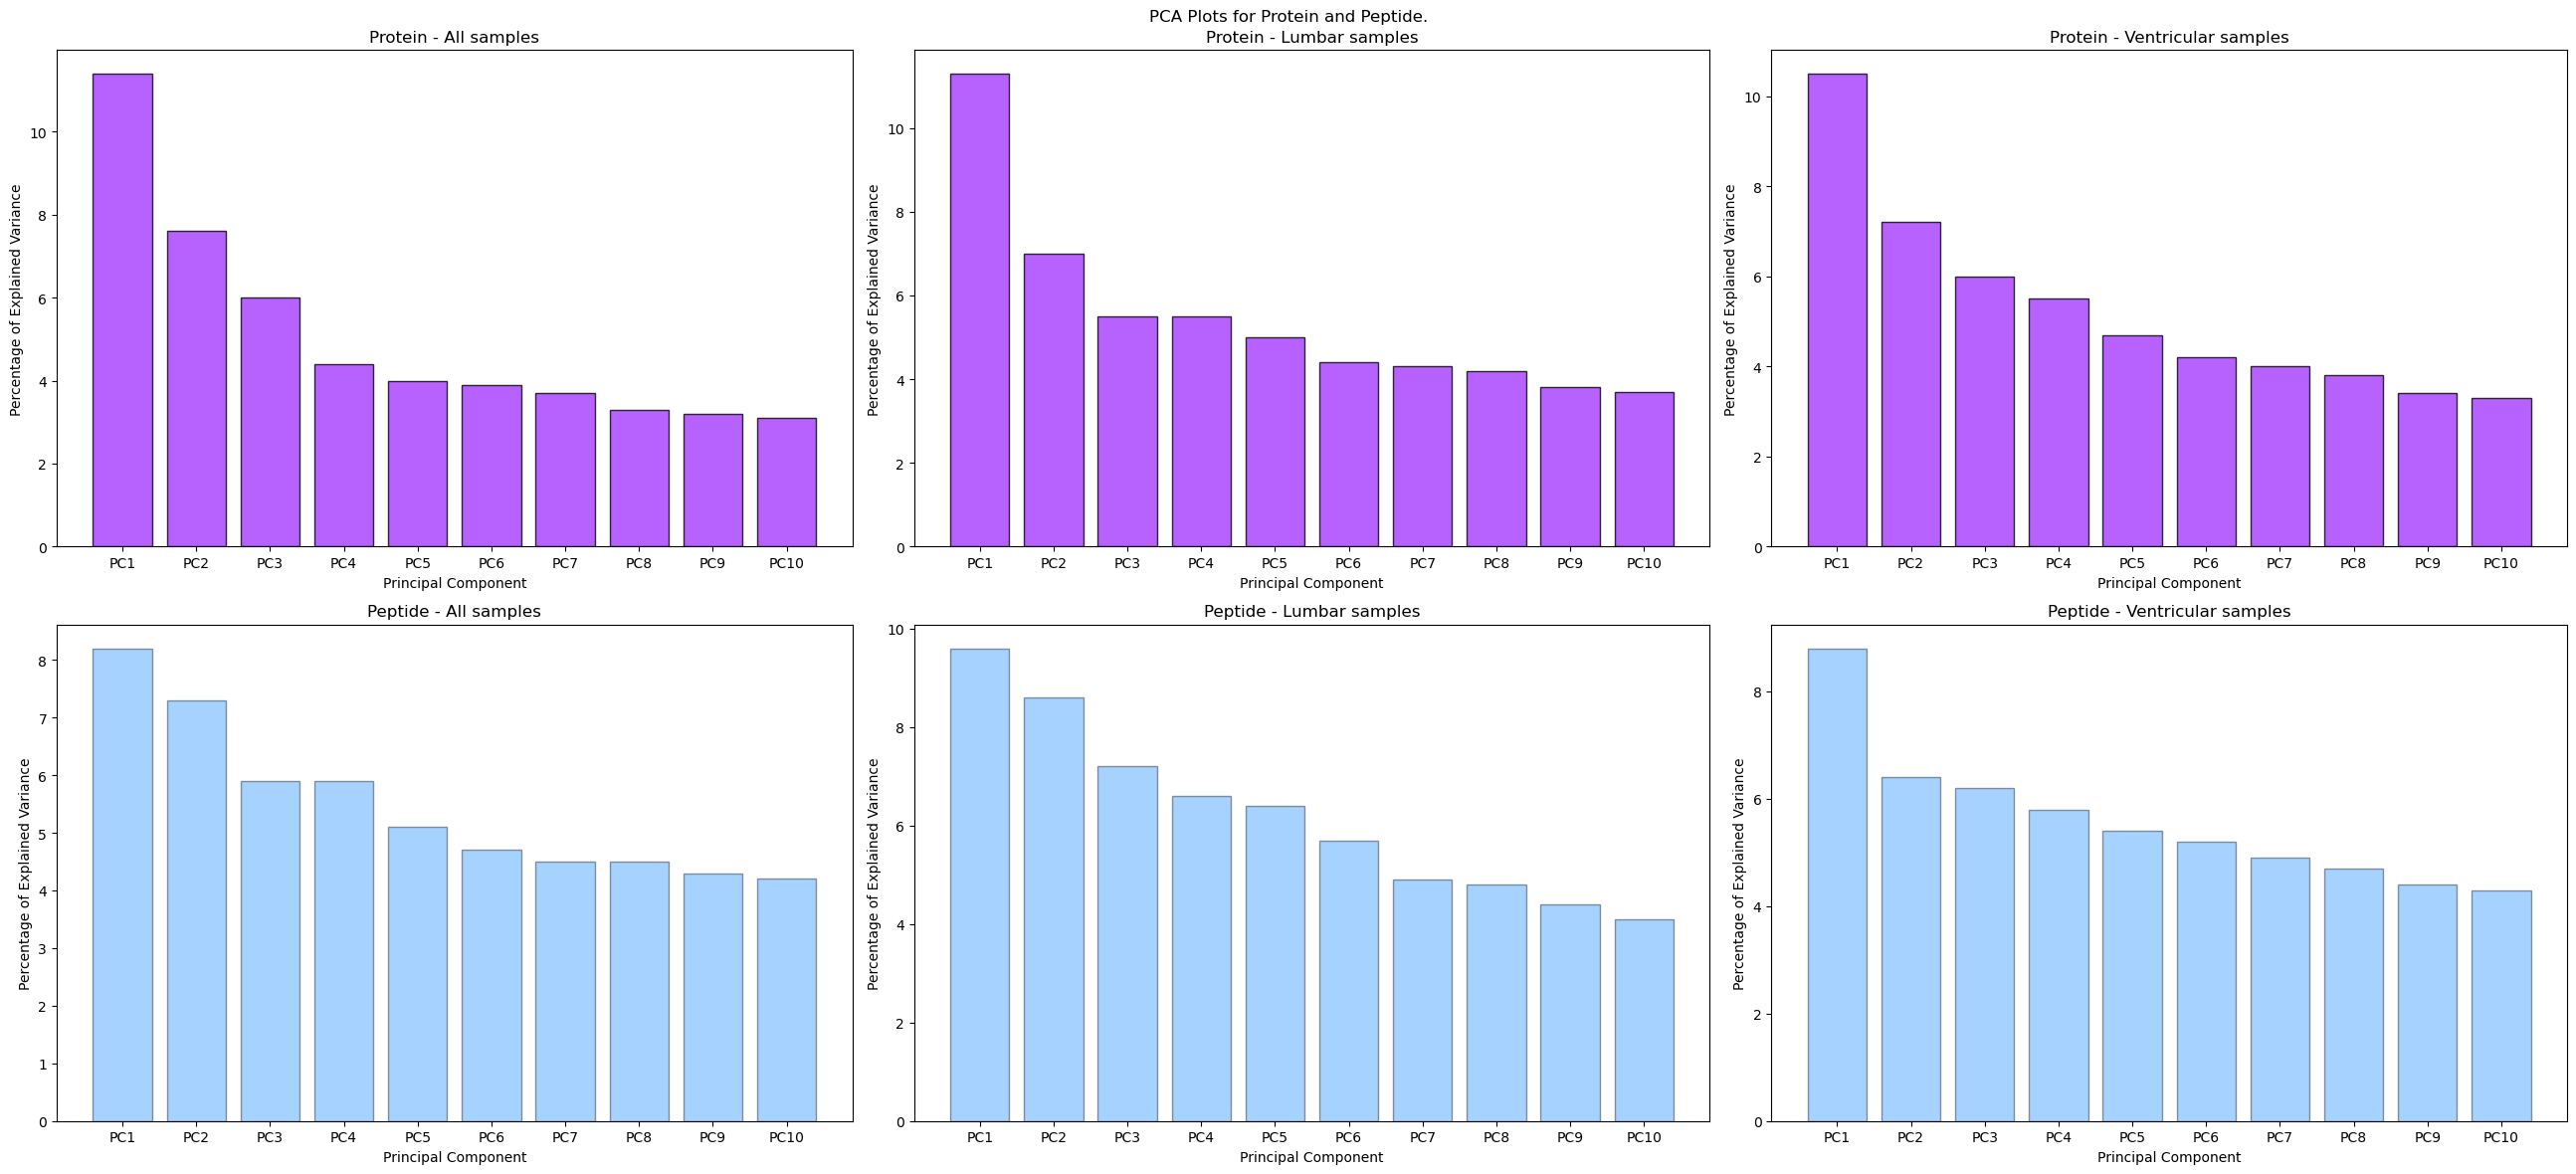

In [34]:
#--- RUNNING PCA CALCULATION AND PLOTTING ---#
datasets_protein = [zero_protein_df.iloc[:, 11:], zero_protein_df[zero_protein_df['CSF_type'] == 'L'].iloc[:, 11:],
                    zero_protein_df[zero_protein_df['CSF_type'] == 'V'].iloc[:, 11:]]
labels_protein = ['Protein - All samples', 'Protein - Lumbar samples', 'Protein - Ventricular samples']

datasets_peptide = [zero_peptide_df.iloc[:, 11:], zero_peptide_df[zero_peptide_df['CSF_type'] == 'L'].iloc[:, 11:],
                     zero_peptide_df[zero_peptide_df['CSF_type'] == 'V'].iloc[:, 11:]]
labels_peptide = ['Peptide - All samples', 'Peptide - Lumbar samples', 'Peptide - Ventricular samples']

fig, axes = plt.subplots(2, 3, figsize=(26, 12))
fig.suptitle('PCA Plots for Protein and Peptide.')

for i, (dataset_protein, label_protein, dataset_peptide, label_peptide) in enumerate(
        zip(datasets_protein, labels_protein, datasets_peptide, labels_peptide)):
    #Protein
    var_protein, labels_protein = do_PCA_on_DF(dataset_protein)
    axes[0, i].bar(x=range(1, len(var_protein) + 1), height=var_protein,
                   tick_label=labels_protein,
                   color='#a539ff', edgecolor='black', alpha=0.8)
    axes[0, i].set_ylabel('Percentage of Explained Variance')
    axes[0, i].set_xlabel('Principal Component')
    axes[0, i].set_title(label_protein)

    #Peptide
    var_peptide, labels_peptide = do_PCA_on_DF(dataset_peptide)
    axes[1, i].bar(x=range(1, len(var_peptide) + 1), height=var_peptide,
                   tick_label=labels_peptide,
                   color='dodgerblue', edgecolor='black', alpha=0.4)
    axes[1, i].set_ylabel('Percentage of Explained Variance')
    axes[1, i].set_xlabel('Principal Component')
    axes[1, i].set_title(label_peptide)

plt.tight_layout()
plt.show()

When imputing with zero when missing data is found, the PCA's are even worse than when removing the data. 

## t-SNE

### Cortical_biopsy_grouping

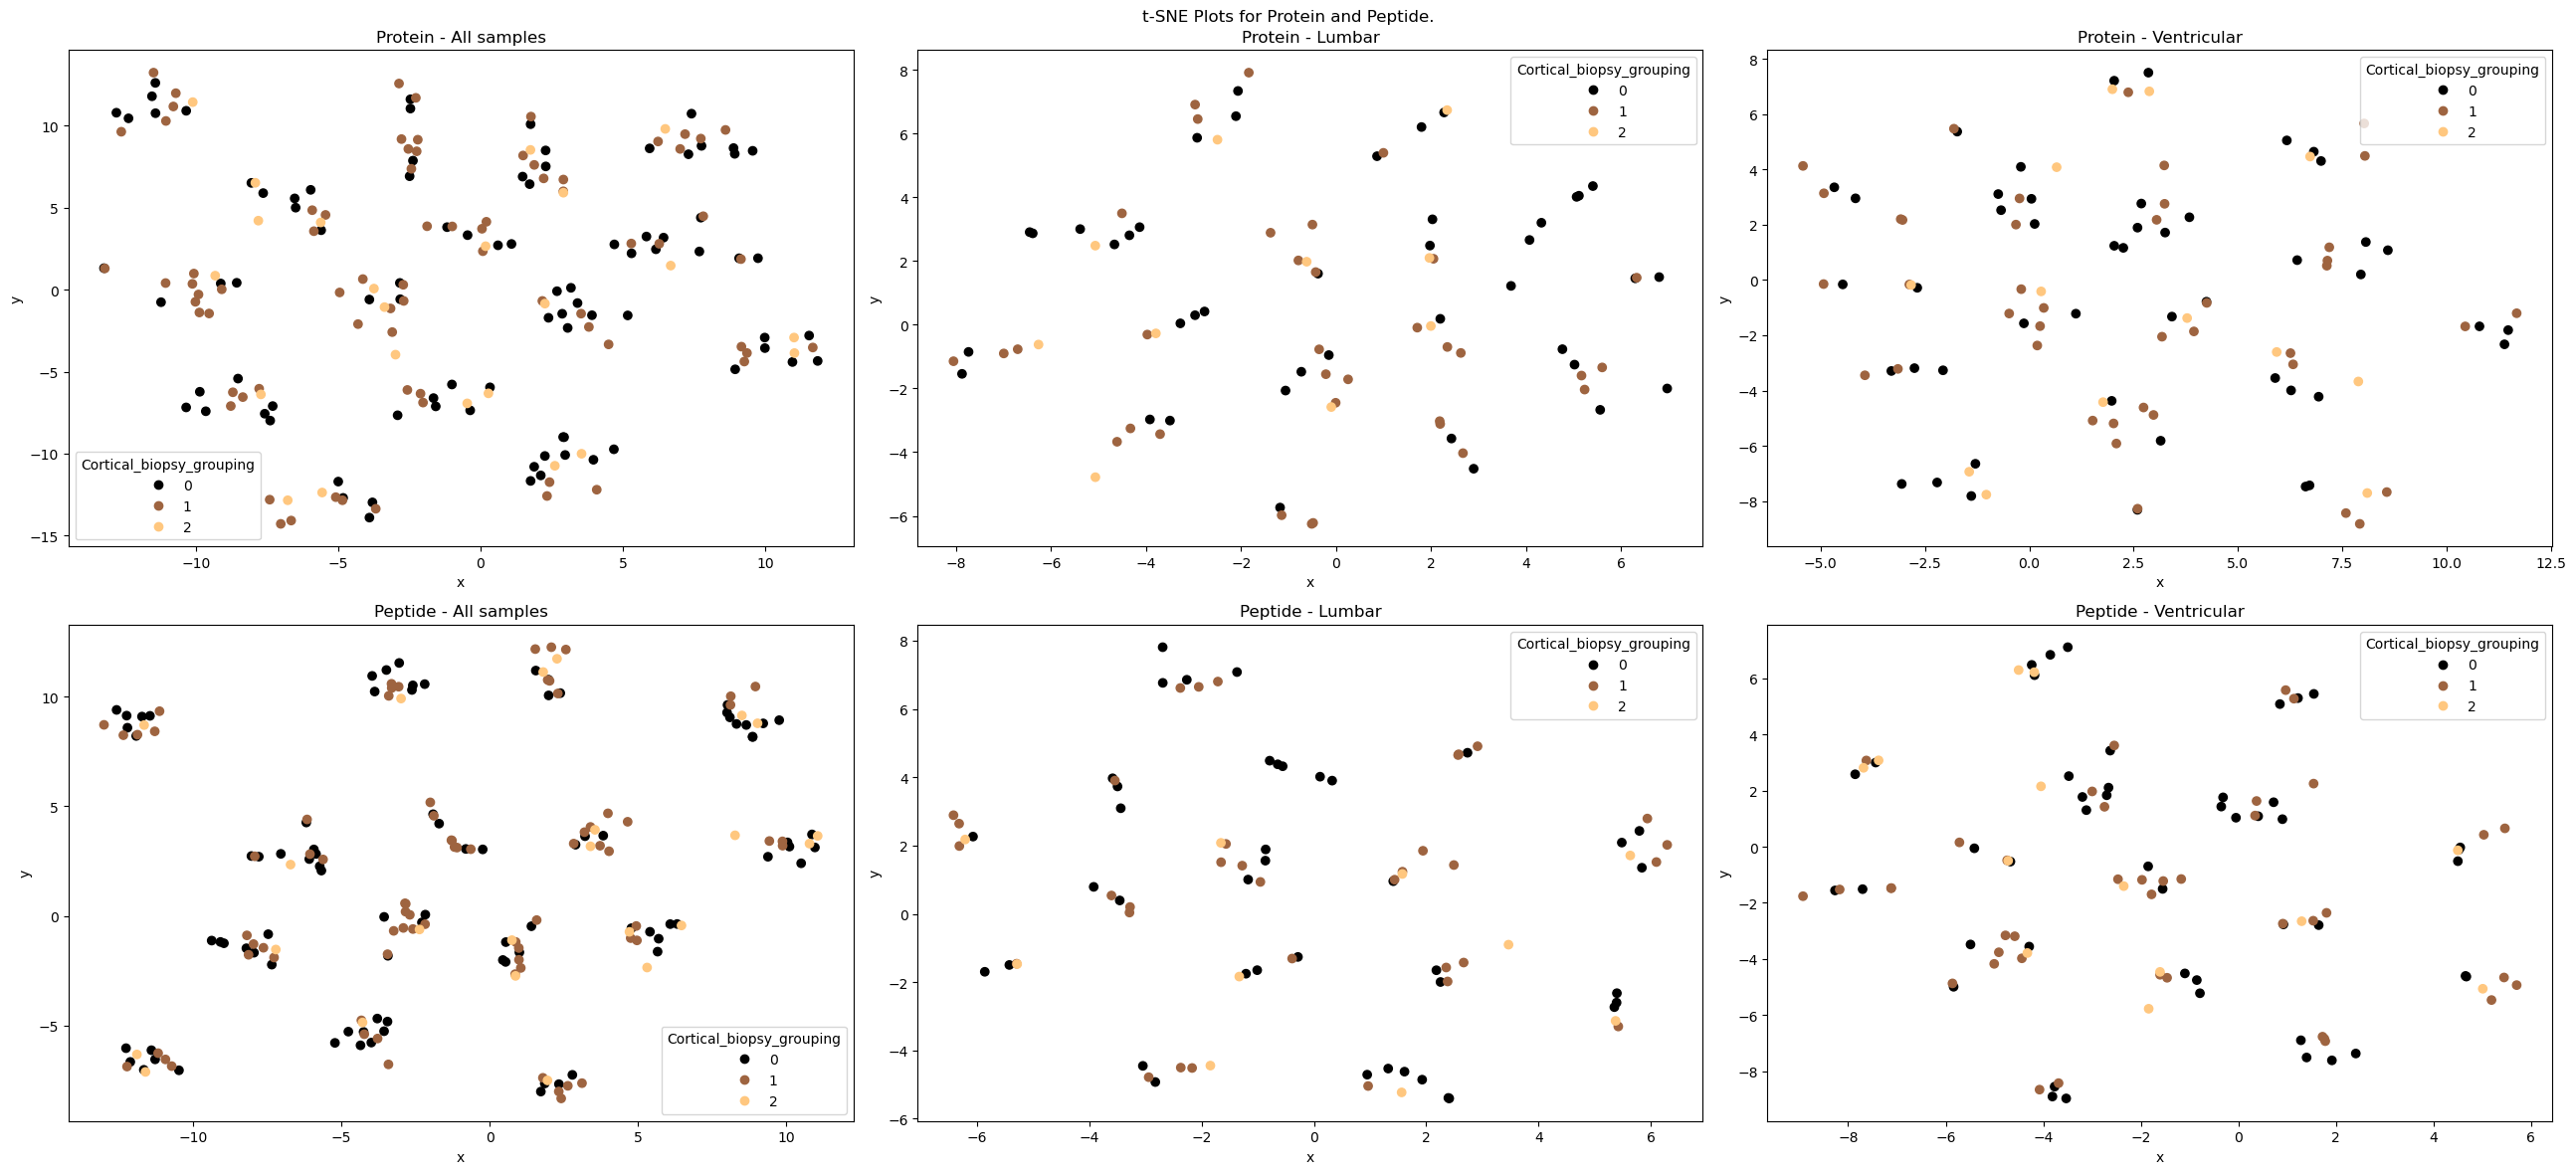

In [35]:
#--- RUNNING t-SNE CALCULATION AND PLOTTING ---#
all_pro_result_df = do_tSNE_on_DF(zero_protein_df, "Cortical_biopsy_grouping")
all_pep_result_df = do_tSNE_on_DF(zero_peptide_df, "Cortical_biopsy_grouping")
l_pro_result_df = do_tSNE_on_DF(zero_protein_df[zero_protein_df['CSF_type'] == 'L'], "Cortical_biopsy_grouping")
l_pep_result_df = do_tSNE_on_DF(zero_peptide_df[zero_peptide_df['CSF_type'] == 'L'], "Cortical_biopsy_grouping")
v_pro_result_df = do_tSNE_on_DF(zero_protein_df[zero_protein_df['CSF_type'] == 'V'], "Cortical_biopsy_grouping")
v_pep_result_df = do_tSNE_on_DF(zero_peptide_df[zero_peptide_df['CSF_type'] == 'V'], "Cortical_biopsy_grouping")

types = ['All samples', 'Lumbar', 'Ventricular']
protein_dfs = [all_pro_result_df, l_pro_result_df, v_pro_result_df]
peptide_dfs = [all_pep_result_df, l_pep_result_df, v_pep_result_df]

fig, axes = plt.subplots(2, 3, figsize=(26, 12))
fig.suptitle('t-SNE Plots for Protein and Peptide.')

for i, (protein_df, peptide_df) in enumerate(zip(protein_dfs, peptide_dfs)):
    #Protein
    scatter_protein = axes[0, i].scatter(x=protein_df["x"], y=protein_df["y"], cmap='copper', 
                                       c=protein_df["Cortical_biopsy_grouping"])
    legend_labels_protein = protein_df["Cortical_biopsy_grouping"].unique()
    axes[0, i].legend(scatter_protein.legend_elements()[0], legend_labels_protein, title='Cortical_biopsy_grouping')
    axes[0, i].set_xlabel("x")
    axes[0, i].set_ylabel("y")
    axes[0, i].set_title(f'Protein - {types[i]}')

    #Peptide
    scatter_peptide = axes[1, i].scatter(x=peptide_df["x"], y=peptide_df["y"], cmap='copper', 
                                       c=peptide_df["Cortical_biopsy_grouping"])
    legend_labels_peptide = peptide_df["Cortical_biopsy_grouping"].unique()
    axes[1, i].legend(scatter_peptide.legend_elements()[0], legend_labels_peptide, title='Cortical_biopsy_grouping')
    axes[1, i].set_xlabel("x")
    axes[1, i].set_ylabel("y")
    axes[1, i].set_title(f'Peptide - {types[i]}')

plt.tight_layout()
plt.show()

WHen doing t-SNE on the datasets with zero imputation, we can definatly see groupings a lot more clearly compared to removing missingness features. However, when it comes to classifying the groups according to Cortical_biopsy_grouping (0 = No pathology, 1 = Only Abeta pathology, 2 = Both Abeta and tau pathology), there is no real correlation.

### TMT Set

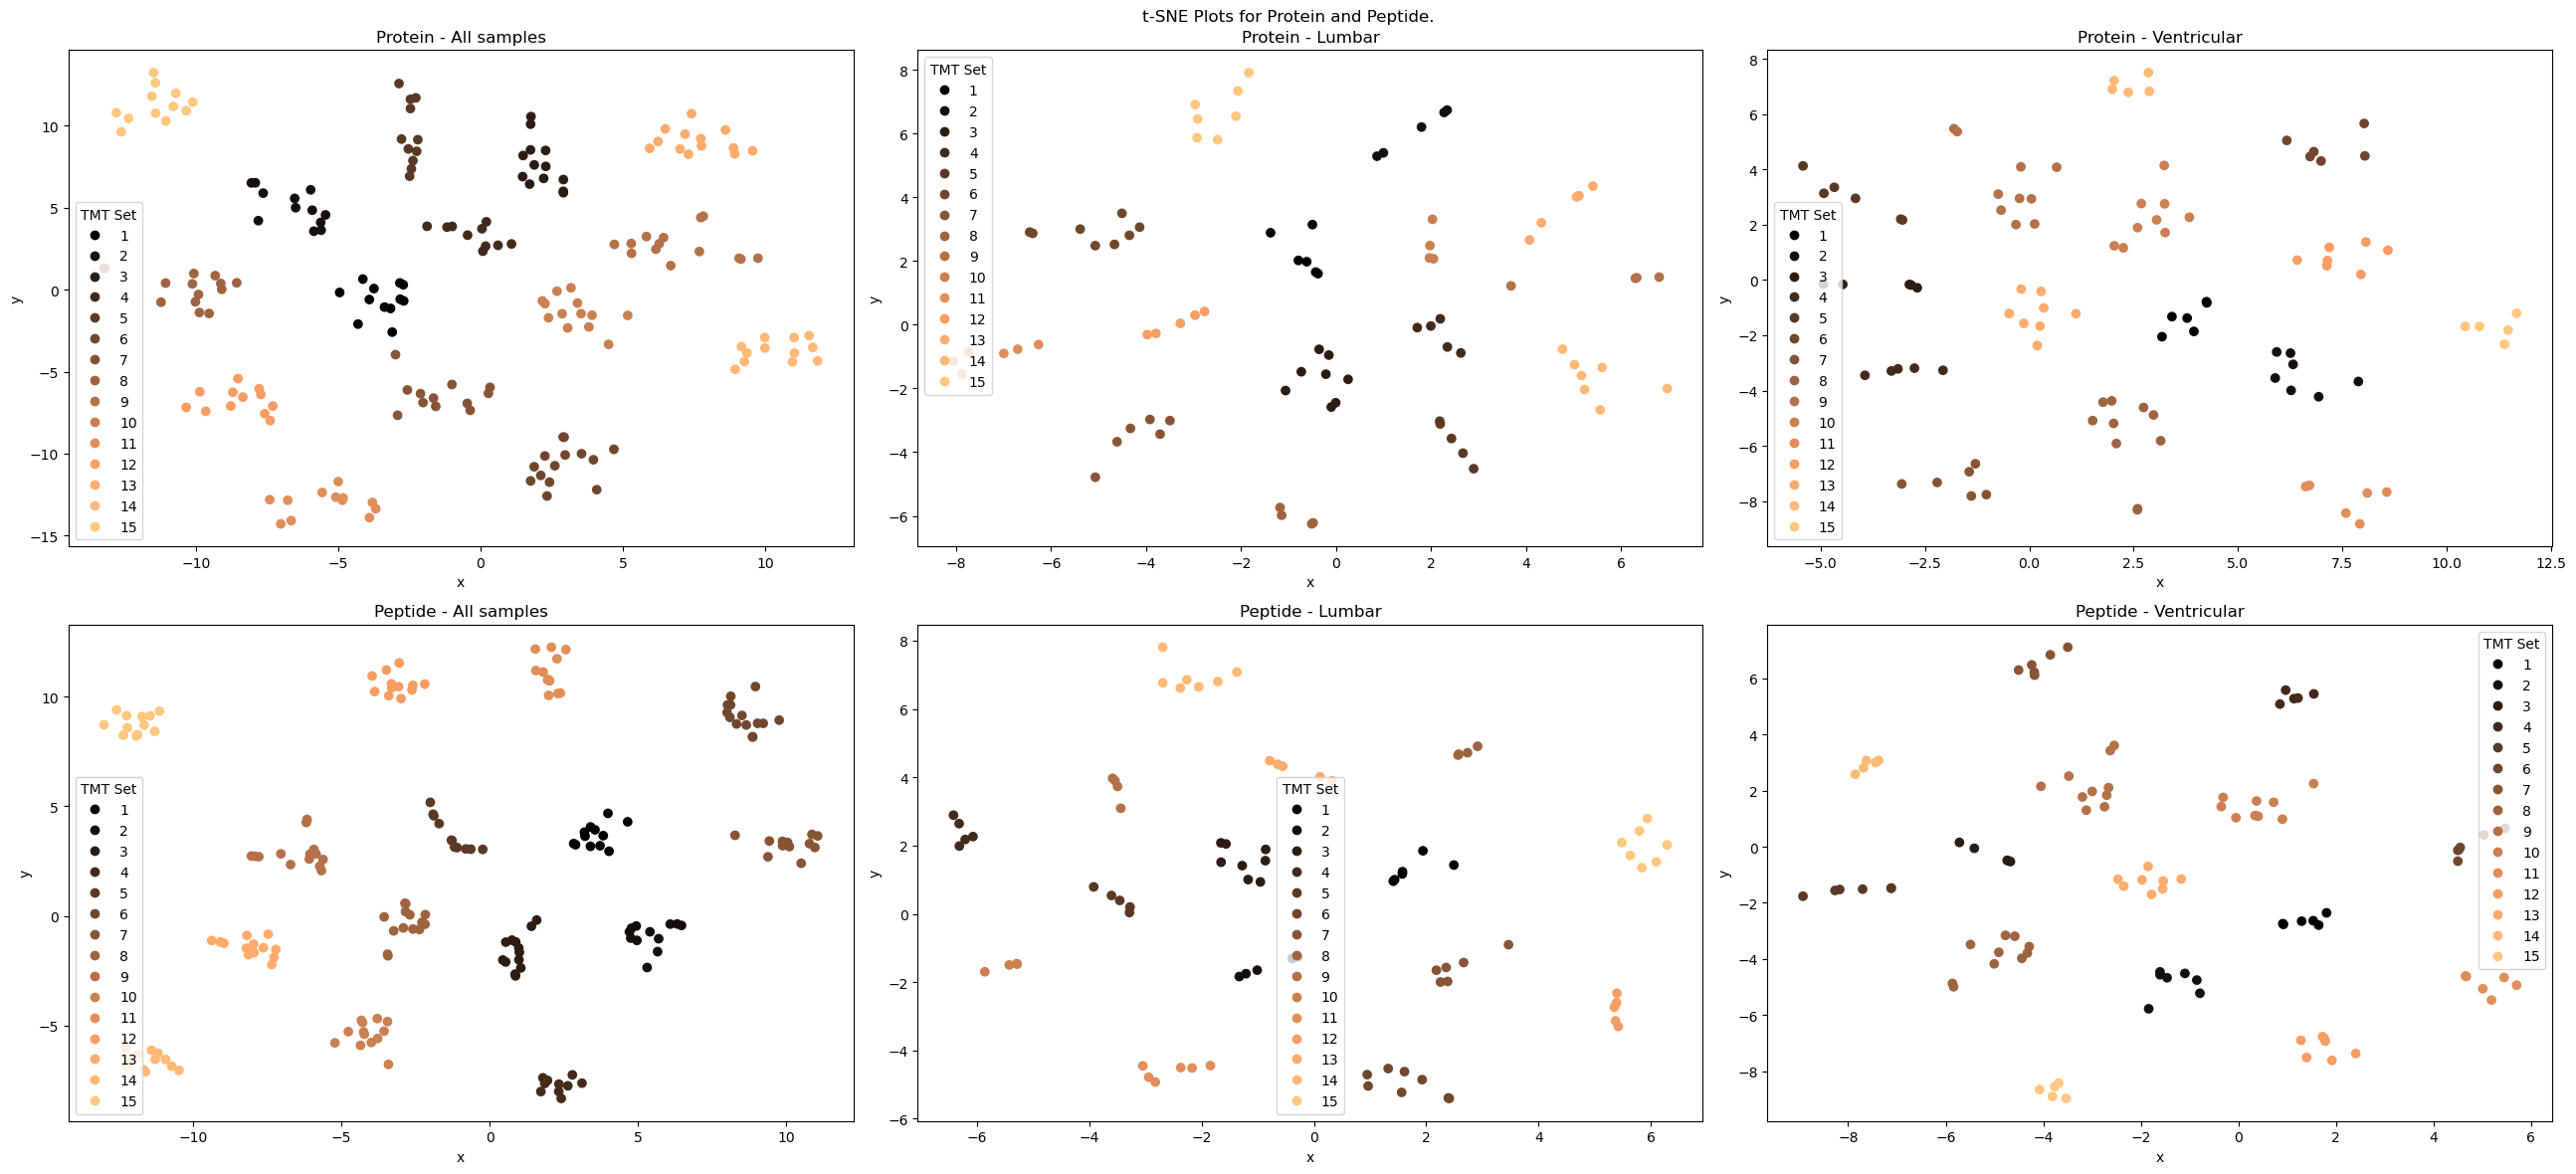

In [36]:
#--- RUNNING t-SNE CALCULATION AND PLOTTING ---#
all_pro_result_df = do_tSNE_on_DF(zero_protein_df,"TMT Set")
all_pep_result_df = do_tSNE_on_DF(zero_peptide_df,"TMT Set")
l_pro_result_df = do_tSNE_on_DF(zero_protein_df[zero_protein_df['CSF_type'] == 'L'],"TMT Set")
l_pep_result_df = do_tSNE_on_DF(zero_peptide_df[zero_peptide_df['CSF_type'] == 'L'],"TMT Set")
v_pro_result_df = do_tSNE_on_DF(zero_protein_df[zero_protein_df['CSF_type'] == 'V'],"TMT Set")
v_pep_result_df = do_tSNE_on_DF(zero_peptide_df[zero_peptide_df['CSF_type'] == 'V'],"TMT Set")

types = ['All samples', 'Lumbar', 'Ventricular']
protein_dfs = [all_pro_result_df, l_pro_result_df, v_pro_result_df]
peptide_dfs = [all_pep_result_df, l_pep_result_df, v_pep_result_df]

fig, axes = plt.subplots(2, 3, figsize=(26, 12))
fig.suptitle('t-SNE Plots for Protein and Peptide.')

for i, (protein_df, peptide_df) in enumerate(zip(protein_dfs, peptide_dfs)):
    #Protein
    scatter_protein = axes[0, i].scatter(x=protein_df["x"], y=protein_df["y"], cmap='copper', 
                                       c=protein_df["TMT Set"])
    legend_labels_protein = protein_df["TMT Set"].unique()
    axes[0, i].legend(scatter_protein.legend_elements()[0], legend_labels_protein, title='TMT Set')
    axes[0, i].set_xlabel("x")
    axes[0, i].set_ylabel("y")
    axes[0, i].set_title(f'Protein - {types[i]}')

    #Peptide
    scatter_peptide = axes[1, i].scatter(x=peptide_df["x"], y=peptide_df["y"], cmap='copper', 
                                       c=peptide_df["TMT Set"])
    legend_labels_peptide = peptide_df["TMT Set"].unique()
    axes[1, i].legend(scatter_peptide.legend_elements()[0], legend_labels_peptide, title='TMT Set')
    axes[1, i].set_xlabel("x")
    axes[1, i].set_ylabel("y")
    axes[1, i].set_title(f'Peptide - {types[i]}')

plt.tight_layout()
plt.show()

When looking at the TMT Sets based on the datasets with zero imputation, we can see a very clear correlation between TMT Set and grouping with t-SNE. This suggest a heavy correlation, and is a sign of batch effect. This makes sense, as the different TMT Sets most likely have different proteins and peptides that have only 0 values (from the imputation), which easily distinguishes them from the other sets. The goal would be to find a imputation method that removes as few features as possible, and stil results in as much entrophy as possible, as that would mean that the batch effect has been removed efficiently. Further on, if features have to be removed (in case of high missingness), a zero imputation t-SNE should be compared to a "good imputation" t-SNE on the same sup-dataset, in order to determine if enough batch effect has been removed.

## Random Forest Feature Extraction

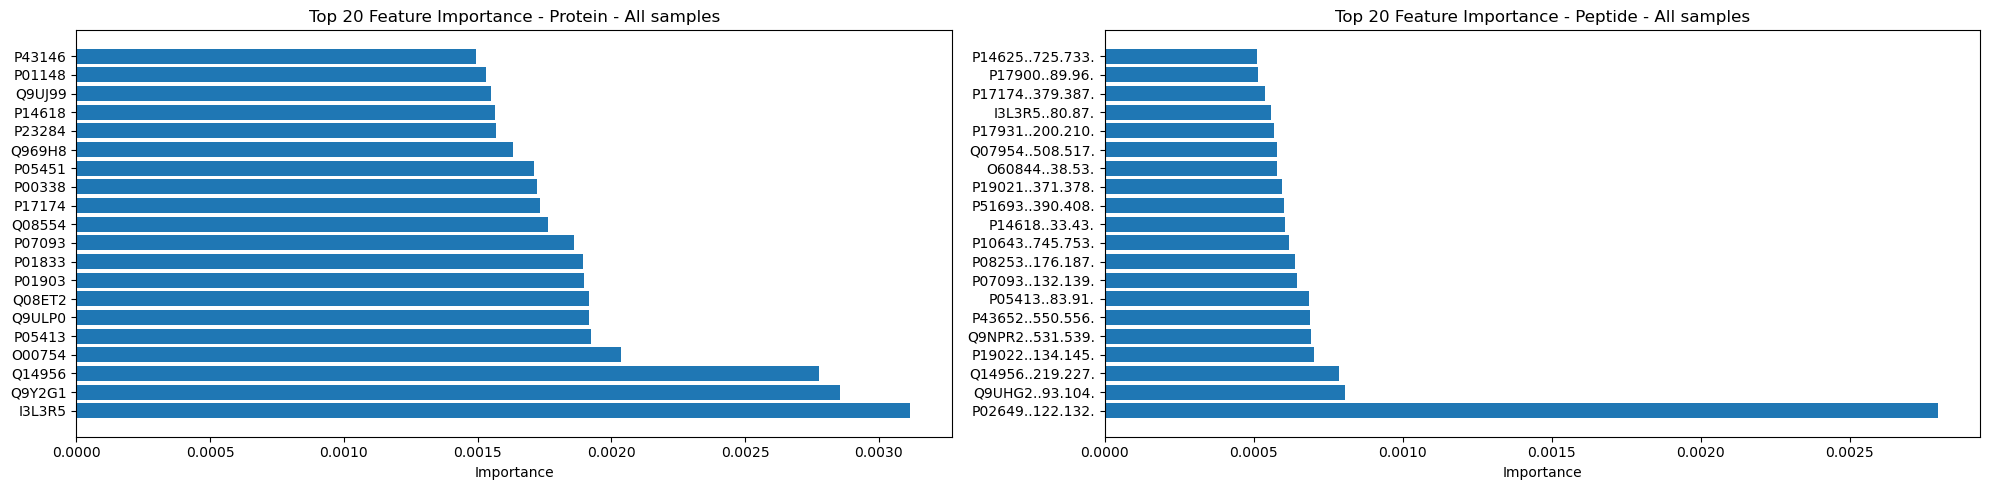

In [37]:
#--- RUNNING RANDOM FOREST FEATURE IMPORTANCE EXTRACTION AND PLOTTING - ALL SAMPLES ---#
protein_features_all_0 = random_forest_feature_extraction(zero_protein_df, "Cortical_biopsy_grouping", 100)
peptide_features_all_0 = random_forest_feature_extraction(zero_peptide_df, "Cortical_biopsy_grouping", 100)

visualize_top_features(protein_features_all_0, peptide_features_all_0, 20)

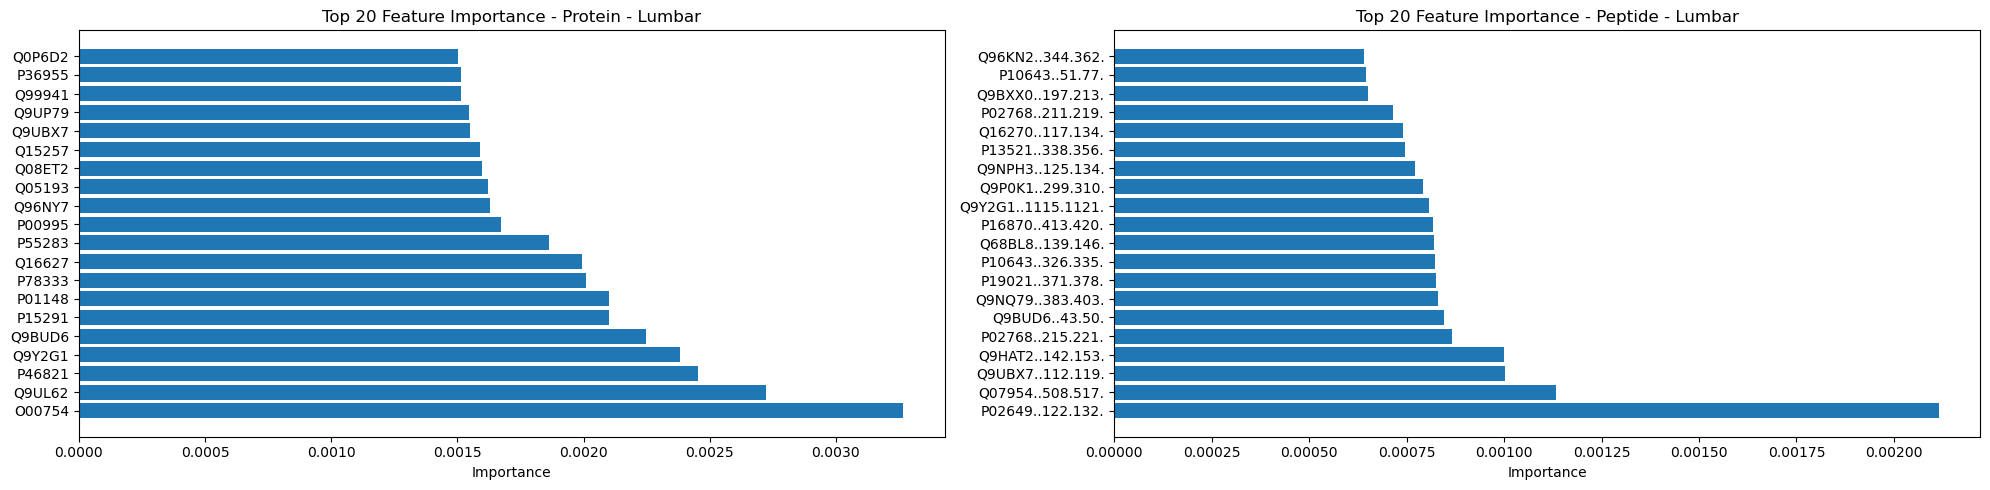

In [38]:
#--- RUNNING RANDOM FOREST FEATURE IMPORTANCE EXTRACTION AND PLOTTING - LUMBAR ---#
protein_features_l_0 = random_forest_feature_extraction(zero_protein_df[zero_protein_df['CSF_type'] == 'L'], "Cortical_biopsy_grouping", 100)
peptide_features_l_0 = random_forest_feature_extraction(zero_peptide_df[zero_peptide_df['CSF_type'] == 'L'], "Cortical_biopsy_grouping", 100)

visualize_top_features(protein_features_l_0, peptide_features_l_0, 20, "Lumbar")

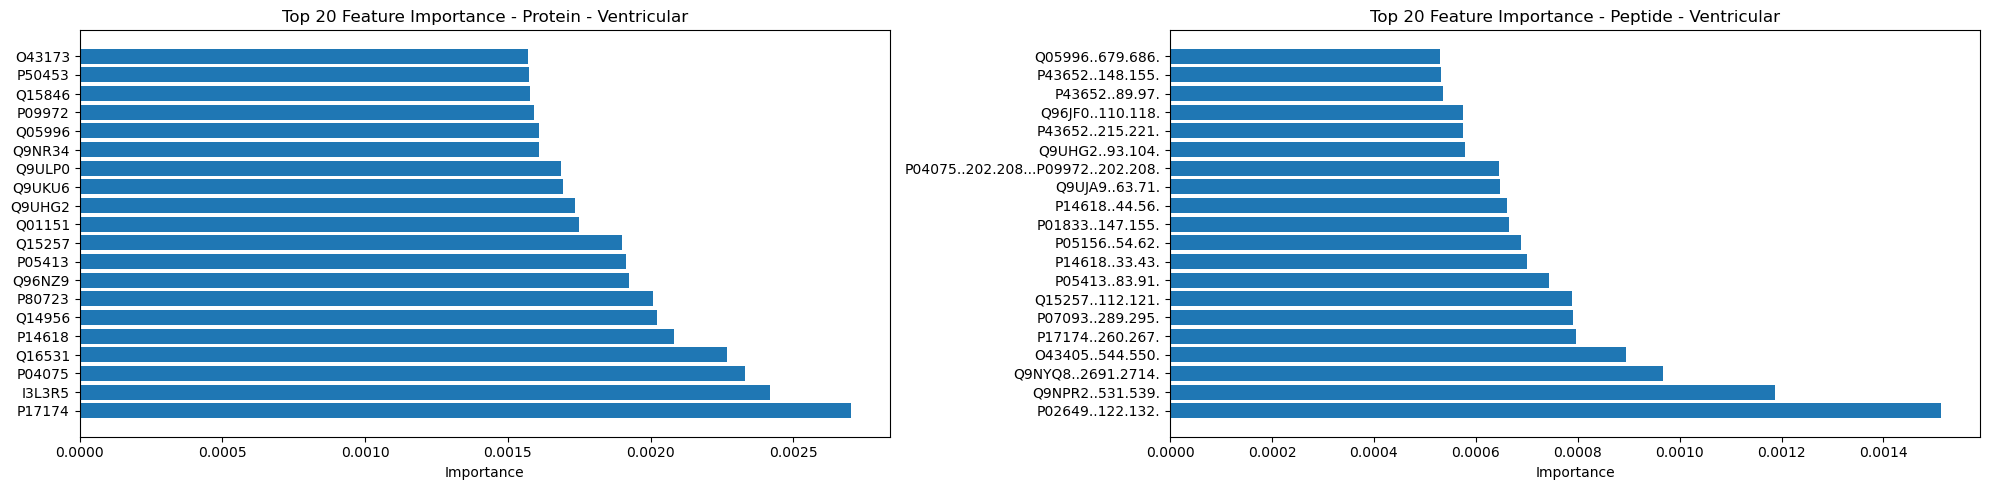

In [39]:
#--- RUNNING RANDOM FOREST FEATURE IMPORTANCE EXTRACTION AND PLOTTING - VENTRICULAR ---#
protein_features_v_0 = random_forest_feature_extraction(zero_protein_df[zero_protein_df['CSF_type'] == 'V'], "Cortical_biopsy_grouping", 100)
peptide_features_v_0 = random_forest_feature_extraction(zero_peptide_df[zero_peptide_df['CSF_type'] == 'V'], "Cortical_biopsy_grouping", 100)

visualize_top_features(protein_features_v_0, peptide_features_v_0, 20, "Ventricular")

As with the random forest feature extraction on the datasets free from missingness, these graphs shows important features on zero imputed datasets, and the results are roughly the same. The peptide samples have slightly more in common compared to the protein datasets. The all samples show some correlation to the top 20 of the lumbar and ventricular data, but some of the proteins and peptides in the all dataset contains features not shown in the top 20.

In [40]:
get_feature_importance_df(protein_features_l_0, protein_features_v_0)

,Lumbar,Ventricular
A0A075B6H9,0.000301,0.000415
A0A075B6I0,0.000419,0.000445
A0A075B6I1,0.000611,0.000640
A0A075B6I4,0.000141,0.000181
A0A075B6I9,0.000514,0.000469
...,...,...
Q9Y6R7,0.000418,0.000461
Q9Y6V0,0.000144,0.000096
Q9Y6X5,0.000587,0.000454
Q9Y6Y9,0.000214,0.000080


# Miscellaneous